In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.power import TTestIndPower

In [136]:
dtype_dict = {
    'route_id': 'int16',
    'bus_id': 'int32',
    'stop_sequence': 'int16',
    'arrival_delay': 'int16',
    'dwell_time': 'uint16',
    'travel_time_for_previous_section': 'uint16',
    'scheduled_travel_time': 'uint16',
    'upstream_stop_delay': 'int16',
    'origin_delay': 'int16',
    'previous_bus_delay': 'int16',
    'previous_trip_travel_time': 'uint16',
    'traffic_condition': 'float32',
    'recurrent_delay': 'float32'
}

dummy_vars = [
    'factor(weather)Light_Rain', 'factor(weather)Light_Snow', 'factor(weather)Normal',
    'factor(weather)Rain', 'factor(weather)Snow', 'factor(temperature)Cold',
    'factor(temperature)Extra_cold', 'factor(temperature)Normal', 'factor(day_of_week)weekday',
    'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
    'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'
]

for var in dummy_vars:
    dtype_dict[var] = 'uint8'

In [137]:
data_path = 'data/Dataset-PT.csv'

df = pd.read_csv(
    data_path,
    dtype=dtype_dict,
    parse_dates=['Calendar_date'],
    date_format='%Y%m%d'
)

numeric_cols = [
    'arrival_delay', 'dwell_time', 'travel_time_for_previous_section',
    'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
    'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
    'recurrent_delay'
]

categorical_columns = ['weather', 'temperature', 'day_of_week', 'time_of_day']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Validación de las variables dummy
for var in dummy_vars:
    if not df[var].isin([0, 1]).all():
        raise ValueError(f"La variable {var} contiene valores distintos de 0 y 1")

In [138]:
df.insert(1, 'day_of_week_num', df['Calendar_date'].dt.dayofweek)

# Calculo Estadísticas

## Variables Continuas

In [139]:
def calcular_estadisticas_continuas(df, cols):
    # Crear un diccionario para almacenar resultados
    stats_dict = {
        'Variable': [],
        'Media': [],
        'Mediana': [],
        'Desviación Estándar': [],
        'Percentil 95%': [],
        'Máximo': []
    }
    
    # Calcular estadísticas para cada columna
    for col in cols:
        stats_dict['Variable'].append(col)
        stats_dict['Media'].append(df[col].mean())
        stats_dict['Mediana'].append(df[col].median())
        stats_dict['Desviación Estándar'].append(df[col].std())
        stats_dict['Percentil 95%'].append(df[col].quantile(0.95))
        stats_dict['Máximo'].append(df[col].max())
    
    # Convertir el diccionario a un DataFrame
    stats_df = pd.DataFrame(stats_dict)
    
    # Imprimir la tabla en formato tabular
    print("\n### Estadísticas Descriptivas para Variables Continuas ###\n")
    print(stats_df.to_markdown(index=False))
    
    return stats_df

# Calcular estadísticas descriptivas para las variables continuas
estadisticas_continuas = calcular_estadisticas_continuas(df, numeric_cols)


### Estadísticas Descriptivas para Variables Continuas ###

| Variable                         |    Media |   Mediana |   Desviación Estándar |   Percentil 95% |    Máximo |
|:---------------------------------|---------:|----------:|----------------------:|----------------:|----------:|
| arrival_delay                    | 134.972  |   88      |              193.899  |         513     |  2257     |
| dwell_time                       |  31.9947 |   25      |               27.2157 |          80     |  1616     |
| travel_time_for_previous_section |  71.441  |   64      |               37.5906 |         137     |  1069     |
| scheduled_travel_time            | 105.918  |  104      |               36.421  |         180     |   198     |
| upstream_stop_delay              | 135.652  |   86      |              190.272  |         510     |  2257     |
| origin_delay                     |  75.1072 |   27      |              133.626  |         354     |  1812     |
| previous_bus_delay       

## Variables categóricas

In [140]:
def calcular_frecuencias_categoricas(df, cols):
    print("\n### Frecuencias Absolutas y Relativas para Variables Categóricas ###\n")

    # Iterar sobre las columnas categóricas para calcular las frecuencias
    for col in cols:
        absolute_freq = df[col].value_counts()
        relative_freq = df[col].value_counts(normalize=True) * 100

        # Combinar frecuencias absolutas y relativas en un solo DataFrame
        freq_df = pd.DataFrame({
            'Frecuencia Absoluta': absolute_freq,
            'Frecuencia Relativa (%)': relative_freq
        }).reset_index().rename(columns={'index': col})

        # Imprimir la tabla en formato tabular
        print(f"\nFrecuencias para {col}:\n")
        print(freq_df.to_markdown(index=False))


# Aplicar la función a todas las variables categóricas
variables_categoricas = ['weather', 'temperature', 'day_of_week', 'time_of_day']
calcular_frecuencias_categoricas(df, variables_categoricas)


### Frecuencias Absolutas y Relativas para Variables Categóricas ###


Frecuencias para weather:

| weather    |   Frecuencia Absoluta |   Frecuencia Relativa (%) |
|:-----------|----------------------:|--------------------------:|
| Normal     |                514971 |                 94.4722   |
| Light Rain |                 13338 |                  2.44688  |
| Light Snow |                  9720 |                  1.78315  |
| Snow       |                  3699 |                  0.678587 |
| Rain       |                  3375 |                  0.619149 |

Frecuencias para temperature:

| temperature   |   Frecuencia Absoluta |   Frecuencia Relativa (%) |
|:--------------|----------------------:|--------------------------:|
| Normal        |                473877 |                  86.9335  |
| Cold          |                 61452 |                  11.2735  |
| Extra cold    |                  9774 |                   1.79306 |

Frecuencias para day_of_week:

| day_of_week   | 

## Variables Continuas por Día de la semana

In [141]:
def calcular_estadisticas_por_dia_semana(df, cols):
    # Agrupar por day_of_week_num (0=Lunes, ..., 6=Domingo) y calcular estadísticas
    grouped_stats = df.groupby('day_of_week_num')[cols].agg(['mean', 'std']).reset_index()

    # Retornar el DataFrame con estadísticas agrupadas
    return grouped_stats

# Calcular estadísticas agregadas por día de la semana excluyendo ciertas variables
estadisticas_por_dia_semana = calcular_estadisticas_por_dia_semana(df, numeric_cols_filtradas)
estadisticas_por_dia_semana

day_of_week_num arrival_delay             dwell_time             \
                           mean         std       mean        std   
0               0     93.867388  154.355705  32.849864  27.124447   
1               1    113.019164  167.005684  33.440333  27.439173   
2               2    122.947733  191.527009  33.279306  27.225144   
3               3    130.577944  197.876176  33.061258  28.177965   
4               4    122.213895  198.946633  32.558489  27.491967   
5               5    194.119135  208.720187  28.880151  26.156917   
6               6    205.849989  224.513593  27.646395  25.585048   

  upstream_stop_delay             previous_bus_delay              \
                 mean         std               mean         std   
0           95.863022  150.102983          93.532564  157.852768   
1          114.143172  163.023020         113.203485  166.610019   
2          123.998703  188.216605         122.347999  191.470426   
3          131.410663  194.201991         128.663146  193.383090   
4          123.697759  194.820103         122.394199  199.092044   
5          192.317628  206.118876         193.359935  209.251055   
6          204.840912  222.156145         204.709931  224.623913   

  previous_trip_travel_time             traffic_condition             \
                       mean         std              mean        std   
0                 74.038788   36.169649         74.045441  32.538769   
1                 74.817713   35.353487         74.787613  31.968313   
2                 74.936091   35.742338         74.928986  32.326237   
3                 74.824520   36.064721         74.797745  32.478577   
4                 74.637316   37.955645         74.607124  34.522602   
5                 73.712263  565.744234         68.755112  30.261444   
6                 67.150267   33.272113         67.093437  30.232542   

  recurrent_delay             
             mean        std  
0       73.475121  29.664040  
1       73.831070  29.609947  
2       74.113617  29.700743  
3       74.841293  30.017424  
4       74.443680  29.853054  
5       68.866676  28.693089  
6       66.847786  28.114079

## Variables Continuas por Stop Sequence

In [142]:
def calcular_estadisticas_por_grupo(df, group_by_col, cols_continuas):
    grouped_stats = df.groupby(group_by_col)[cols_continuas].agg(['mean', 'median', 'std'])
    print(f"\n### Estadísticas Agregadas por {group_by_col} ###\n")
    return grouped_stats


# Estadísticas agregadas por número de parada (stop_sequence)
estadisticas_por_parada = calcular_estadisticas_por_grupo(df, 'stop_sequence', numeric_cols)
estadisticas_por_parada


### Estadísticas Agregadas por stop_sequence ###



arrival_delay                    dwell_time                    \
                       mean median         std       mean median        std   
stop_sequence                                                                 
1                 63.961117   22.0  145.566785   0.402546    0.0  11.353929   
2                100.140274   60.0  150.182380  64.577096   59.0  30.563797   
3                 92.829660   54.0  152.244160  20.506167   20.0  14.309873   
4                 65.273961   29.0  157.159572  29.624598   27.0  13.692514   
5                107.407251   65.0  156.259919  49.767646   43.0  25.926348   
6                138.431671   97.0  160.266349  30.047452   28.0  13.814121   
7                128.251226   88.0  164.838097  24.786765   24.0  11.707203   
8                106.233593   68.0  171.644522  23.099064   22.0  10.800178   
9                136.354797   93.0  171.465535  57.596067   53.0  26.178499   
10               161.177473  119.0  176.470361  32.704493   30.0  17.201352   
11               130.101887   88.0  179.896872  23.570657   22.0  10.411150   
12                89.425182   49.0  182.069784  24.740948   24.0  11.407295   
13               154.455347  105.0  179.442006  74.981871   70.0  49.223641   
14               147.551092  100.0  187.018197  41.276586   37.0  19.500351   
15               155.664223  110.0  192.758800  42.400168   41.0  18.643796   
16               127.777007   85.0  200.912381  26.271187   24.0  16.117105   
17               179.752439  132.0  197.402577  71.405815   60.0  43.079986   
18               208.634504  162.0  202.633034  31.493833   27.0  18.200726   
19               208.887761  162.0  205.533794  28.829313   27.0  18.320123   
20               178.565209  133.0  209.287971  29.793303   25.0  20.720706   
21               170.589777  123.0  210.290436  36.174253   31.0  19.064053   
22               160.839764  113.0  213.719941  15.378325   16.0  11.925414   
23               156.035366  110.0  216.145907  14.830601   15.0   9.838297   
24               132.272277   88.0  220.344312  17.113478   17.0   9.873198   
25               146.122393  101.0  222.181308  28.223339   23.0  16.901171   
26               140.759126   97.0  225.188212  11.404428   14.0   8.788070   
27                56.756055   16.0  230.093371  12.855961   15.0   9.844967   

              travel_time_for_previous_section                    \
                                          mean median        std   
stop_sequence                                                      
1                                     0.000000    0.0   0.000000   
2                                   159.178959  149.0  42.172272   
3                                    50.290208   48.0  10.416896   
4                                    44.216207   41.0  10.283314   
5                                   106.851157  100.0  27.207203   
6                                   113.090990  110.0  22.673252   
7                                    53.238249   51.0  16.307714   
8                                    76.197632   74.0  14.398180   
9                                    89.965080   87.0  24.391595   
10                                   40.411164   37.0  11.966426   
11                                  113.120610  110.0  17.681745   
12                                   77.146070   71.0  21.192732   
13                                   44.538065   39.0  15.393913   
14                                   88.021002   87.0  23.262570   
15                                   96.844024   94.0  19.763329   
16                                   55.059290   53.0  11.312977   
17                                  110.318738  105.0  27.350711   
18                                   77.236416   71.0  27.976403   
19                                   87.583238   88.0  29.960161   
20                                   43.487444   41.0  13.868263   
21                                   55.137847   50.0  16.281287   
22         

## Variables Categóricas por Día de la semana

In [143]:
def calcular_frecuencias_categoricas_por_grupo(df, group_by_col, cols_categoricas):
    combined_freq_dict = {}

    # Calcular frecuencias para cada variable categórica por el grupo especificado
    for col in cols_categoricas:
        # Frecuencia absoluta por grupo
        abs_freq = df.groupby(group_by_col)[col].value_counts().unstack().fillna(0)

        # Frecuencia relativa por grupo (proporción)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Combinar frecuencias absolutas y relativas en un solo DataFrame
        combined_freq = pd.concat([rel_freq], axis=1, keys=['(%)'])

        # Reorganizar las columnas para que las frecuencias relativas estén al lado de las absolutas
        combined_freq.columns = [f'{lvl1}_{lvl2}' for lvl1, lvl2 in combined_freq.columns]

        combined_freq_dict[col] = combined_freq

    return combined_freq_dict


# Definir las variables categóricas para el análisis
variables_categoricas = ['weather', 'temperature', 'day_of_week', 'time_of_day']

# Calcular frecuencias para variables categóricas por día de la semana
frecuencias_por_dia_semana = calcular_frecuencias_categoricas_por_grupo(df, 'day_of_week_num', variables_categoricas)

# Mostrar resultados para una variable categórica como ejemplo
for col, freqs in frecuencias_por_dia_semana.items():
    print(f"\n### Frecuencias combinadas para {col} ###\n")
    print(freqs)


### Frecuencias combinadas para weather ###

                 (%)_Light Rain  (%)_Light Snow  (%)_Normal  (%)_Rain  \
day_of_week_num                                                         
0                      4.472843        1.277955   92.939297  0.000000   
1                      0.758265        1.273885   97.088262  0.000000   
2                      0.700579        1.644837   96.466646  1.187938   
3                      2.246094        2.213542   94.986979  0.195312   
4                      3.320650        1.418194   93.497060  0.691802   
5                      5.024116        2.572347   88.987138  2.411576   
6                      0.788955        2.514793   96.696252  0.000000   

                 (%)_Snow  
day_of_week_num            
0                1.309904  
1                0.879588  
2                0.000000  
3                0.358073  
4                1.072293  
5                1.004823  
6                0.000000  

### Frecuencias combinadas para temperature

## Variables Categóricas por Stop Sequence

In [144]:
def calcular_frecuencias_categoricas_por_stop_sequence(df, cols_categoricas):
    combined_freq_dict = {}

    # Calcular frecuencias para cada variable categórica por stop_sequence
    for col in cols_categoricas:
        # Frecuencia absoluta por grupo (stop_sequence)
        abs_freq = df.groupby('stop_sequence')[col].value_counts().unstack().fillna(0)

        # Frecuencia relativa por grupo (proporción)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Crear DataFrame solo con frecuencias relativas
        combined_freq = pd.concat([rel_freq], axis=1, keys=['(%)'])

        # Renombrar las columnas para que reflejen las categorías
        combined_freq.columns = [f'{lvl1}_{lvl2}' for lvl1, lvl2 in combined_freq.columns]

        combined_freq_dict[col] = combined_freq

    return combined_freq_dict


# Calcular frecuencias relativas para variables categóricas por número de parada
frecuencias_por_stop_sequence = calcular_frecuencias_categoricas_por_stop_sequence(df, variables_categoricas)

# Mostrar resultados para una variable categórica como ejemplo
for col, freqs in frecuencias_por_stop_sequence.items():
    print(f"\n### Frecuencias relativas para {col} por stop_sequence ###\n")
    print(freqs)



### Frecuencias relativas para weather por stop_sequence ###

               (%)_Light Rain  (%)_Light Snow  (%)_Normal  (%)_Rain  (%)_Snow
stop_sequence                                                                
1                    2.446877        1.783149   94.472237  0.619149  0.678587
2                    2.446877        1.783149   94.472237  0.619149  0.678587
3                    2.446877        1.783149   94.472237  0.619149  0.678587
4                    2.446877        1.783149   94.472237  0.619149  0.678587
5                    2.446877        1.783149   94.472237  0.619149  0.678587
6                    2.446877        1.783149   94.472237  0.619149  0.678587
7                    2.446877        1.783149   94.472237  0.619149  0.678587
8                    2.446877        1.783149   94.472237  0.619149  0.678587
9                    2.446877        1.783149   94.472237  0.619149  0.678587
10                   2.446877        1.783149   94.472237  0.619149  0.678587
1

# Plots Media y Desviación Std.

## Variables Continuas Vs. Día de la semana

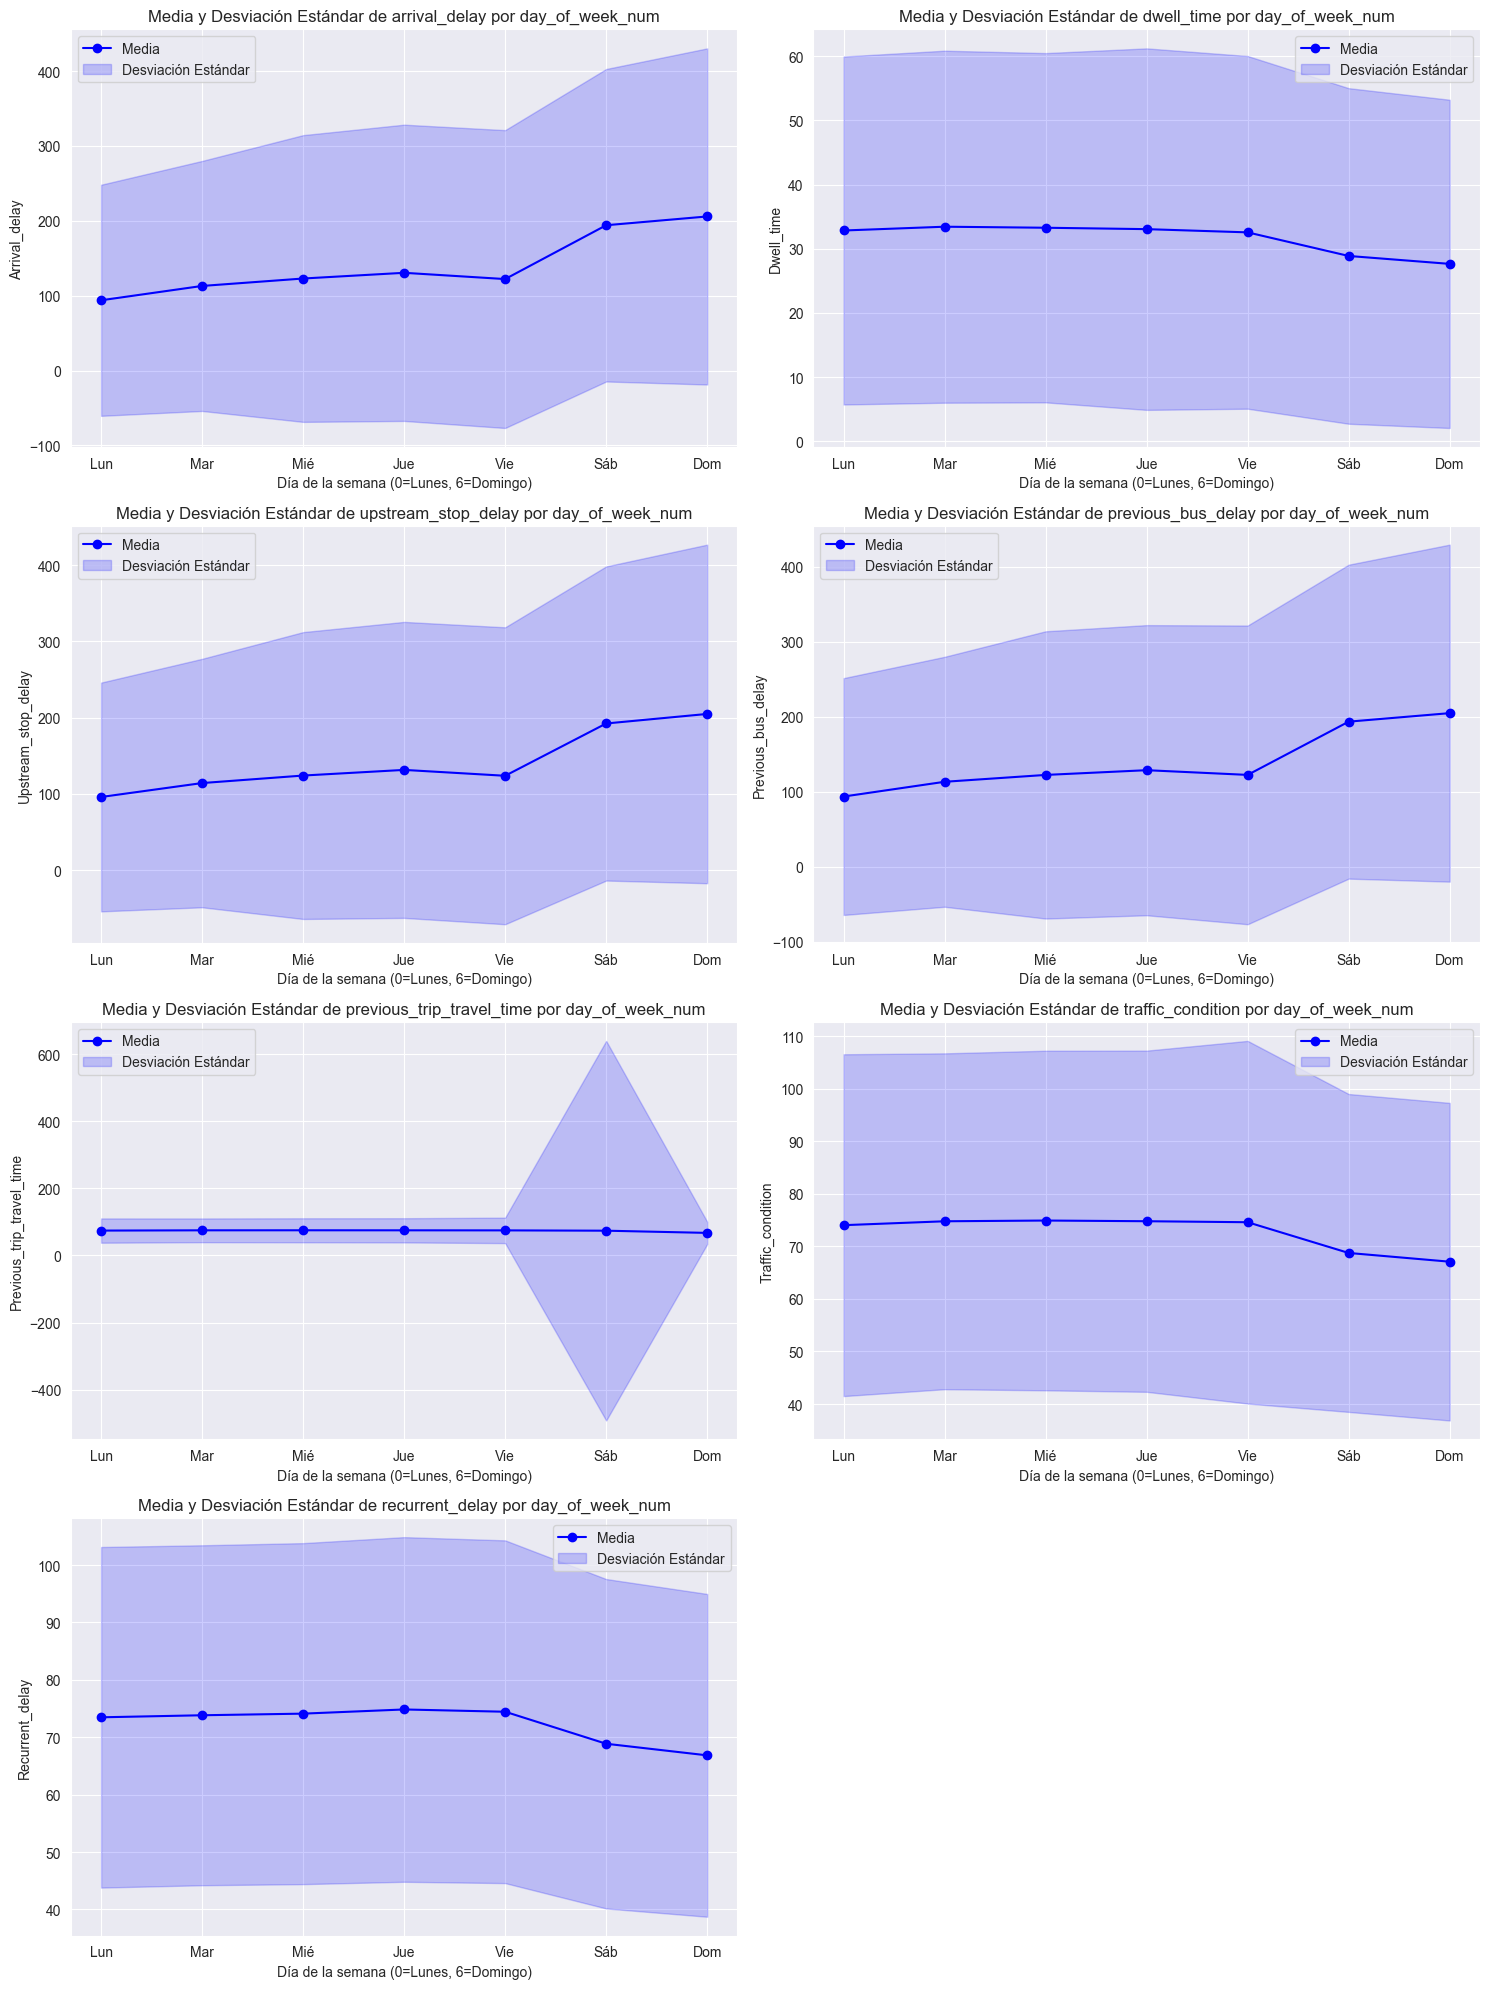

In [145]:
excluir_vars = ['travel_time_for_previous_section', 'scheduled_travel_time', 'origin_delay']

# Filtrar las variables numéricas excluyendo las especificadas
numeric_cols_filtradas = [col for col in numeric_cols if col not in excluir_vars]


def calcular_y_graficar_por_dia(df, cols, group_by_col='day_of_week_num', excluir=None):
    # Excluir variables si se especifica la lista excluir
    if excluir is not None:
        cols = [col for col in cols if col not in excluir]

    # Agrupar por day_of_week_num y calcular estadísticas
    grouped_stats = df.groupby(group_by_col)[cols].agg(['mean', 'std']).reset_index()

    # Calcular el número de filas necesario para la grilla (2 columnas)
    num_cols = 2
    num_rows = (len(cols) + 1) // num_cols

    # Configurar el tamaño de la figura
    plt.figure(figsize=(15, num_rows * 5))

    # Graficar cada variable continua
    for i, col in enumerate(cols, 1):
        plt.subplot(num_rows, num_cols, i)

        # Extraer media y desviación estándar
        x = grouped_stats[group_by_col]
        y_mean = grouped_stats[(col, 'mean')]
        y_std = grouped_stats[(col, 'std')]

        # Graficar media y franja de desviación estándar
        plt.plot(x, y_mean, label='Media', color='blue', marker='o')
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='Desviación Estándar')

        # Personalización del gráfico
        plt.title(f'Media y Desviación Estándar de {col} por {group_by_col}')
        plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
        plt.ylabel(col.capitalize())
        plt.xticks(ticks=range(7), labels=["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"])  # Etiquetas de los días
        plt.legend()
        plt.grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.show()

    # Retornar estadísticas agrupadas
    return grouped_stats


# Aplicar la función para calcular y graficar las estadísticas por día de la semana excluyendo ciertas variables
estadisticas_por_dia = calcular_y_graficar_por_dia(df, numeric_cols, excluir=excluir_vars)

## Variables Continuas Vs. Stop Sequence

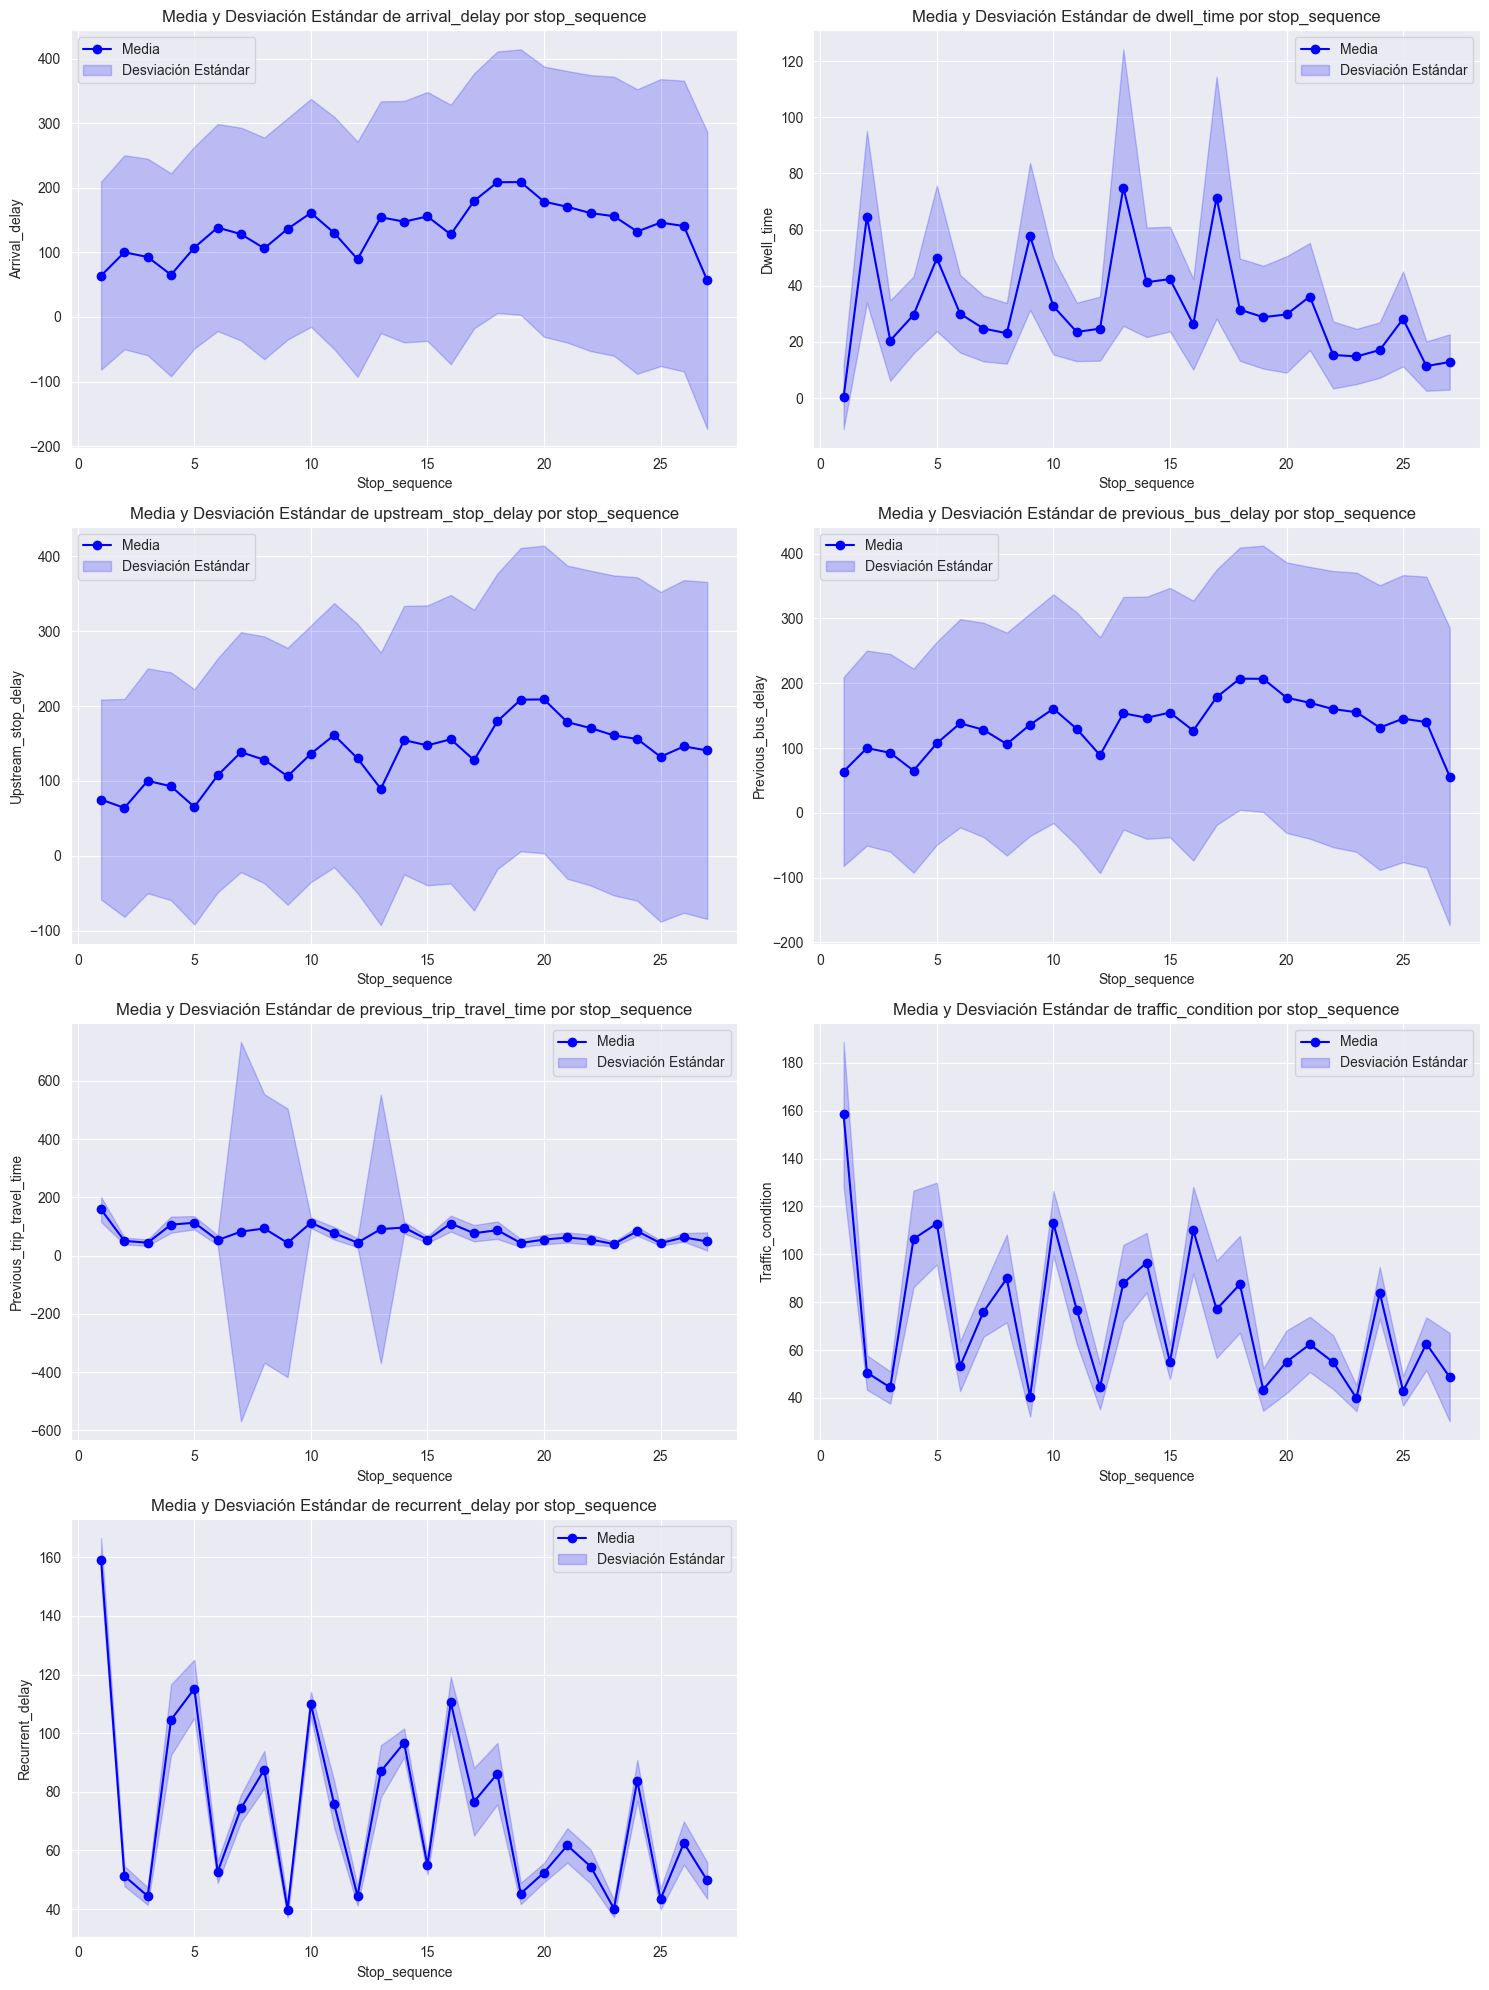

In [146]:
excluir_vars = ['travel_time_for_previous_section', 'scheduled_travel_time', 'origin_delay']

# Filtrar las variables numéricas excluyendo las especificadas
numeric_cols_filtradas = [col for col in numeric_cols if col not in excluir_vars]


def plot_media_desviacion_por_parada(df, cols, group_by_col='stop_sequence'):
    # Agrupar por parada y calcular estadísticas
    grouped_stats = df.groupby(group_by_col)[cols].agg(['mean', 'std']).reset_index()

    # Calcular el número de filas necesario para la grilla
    num_cols = 2
    num_rows = (len(cols) + 1) // num_cols

    # Configurar el tamaño de la figura
    plt.figure(figsize=(15, num_rows * 5))

    # Graficar cada variable continua
    for i, col in enumerate(cols, 1):
        plt.subplot(num_rows, num_cols, i)

        # Extraer media y desviación estándar
        x = grouped_stats[group_by_col]
        y_mean = grouped_stats[(col, 'mean')]
        y_std = grouped_stats[(col, 'std')]

        # Graficar media y franja de desviación estándar
        plt.plot(x, y_mean, label='Media', color='blue', marker='o')
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.2, label='Desviación Estándar')

        # Personalización del gráfico
        plt.title(f'Media y Desviación Estándar de {col} por {group_by_col}')
        plt.xlabel(group_by_col.capitalize())
        plt.ylabel(col.capitalize())
        plt.legend()
        plt.grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.show()


# Graficar todas las variables continuas filtradas por parada
plot_media_desviacion_por_parada(df, numeric_cols_filtradas)

## Variables Categóricas Vs. Día de la Semana

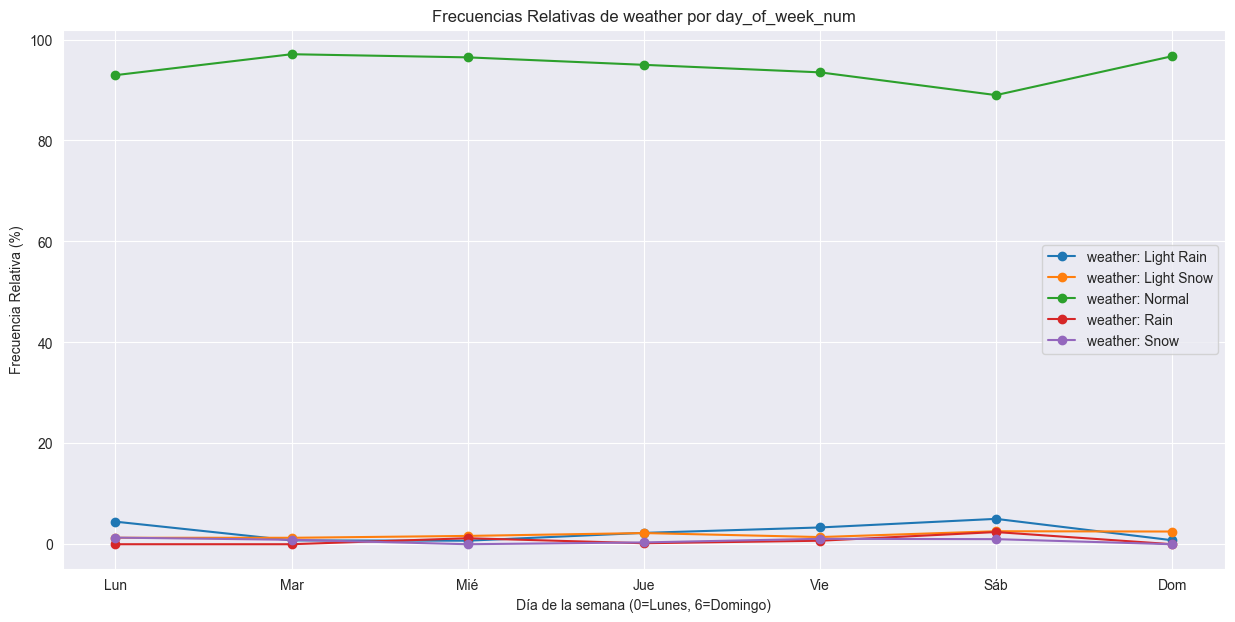

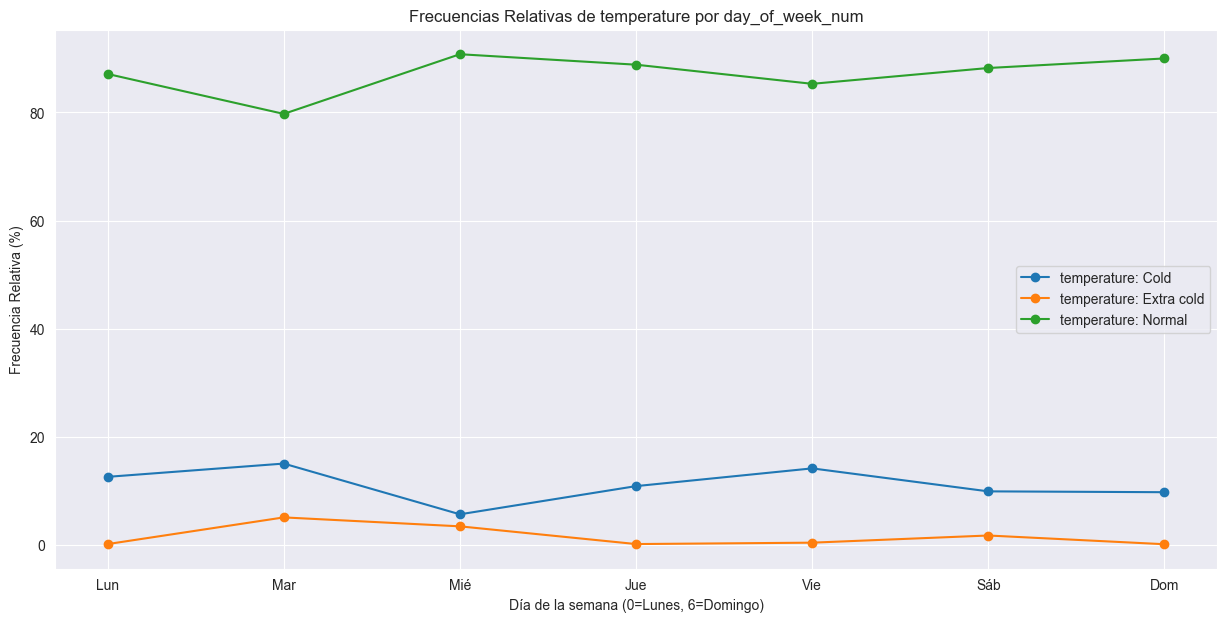

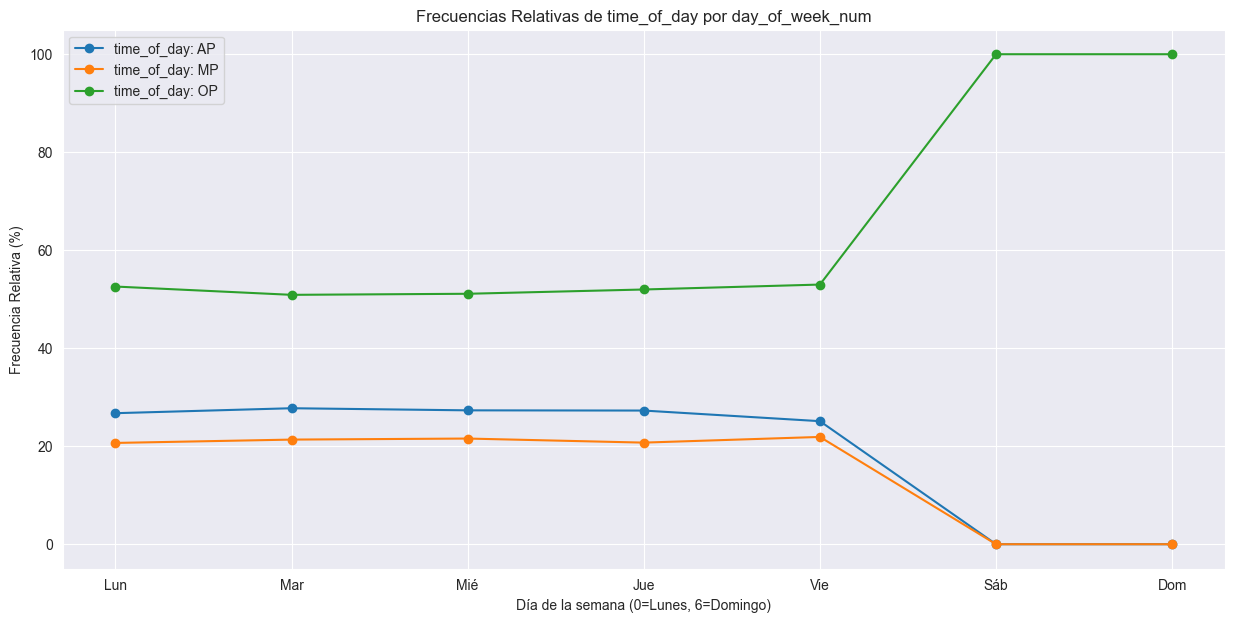

In [147]:
excluir_vars_categoricas = ['day_of_week']

def plot_frecuencias_categoricas_por_dia(df, cols_categoricas, group_by_col='day_of_week_num'):
    # Calcular frecuencias relativas por grupo (día de la semana)
    for col in cols_categoricas:
        # Calcular frecuencias absolutas y luego relativas
        abs_freq = df.groupby(group_by_col)[col].value_counts().unstack().fillna(0)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Configurar el tamaño de la figura
        plt.figure(figsize=(15, 7))

        # Crear gráfico para cada variable categórica
        for category in rel_freq.columns:
            plt.plot(rel_freq.index, rel_freq[category], marker='o', label=f'{col}: {category}')

        # Personalización del gráfico
        plt.title(f'Frecuencias Relativas de {col} por {group_by_col}')
        plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
        plt.ylabel('Frecuencia Relativa (%)')
        plt.xticks(ticks=range(7), labels=["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"])  # Etiquetas de los días
        plt.legend()
        plt.grid(True)

        # Mostrar el gráfico
        plt.show()


# Graficar las frecuencias relativas de las variables categóricas por día de la semana
plot_frecuencias_categoricas_por_dia(df, variables_categoricas_filtradas)

## Variables Categóricas Vs. Stop Sequence

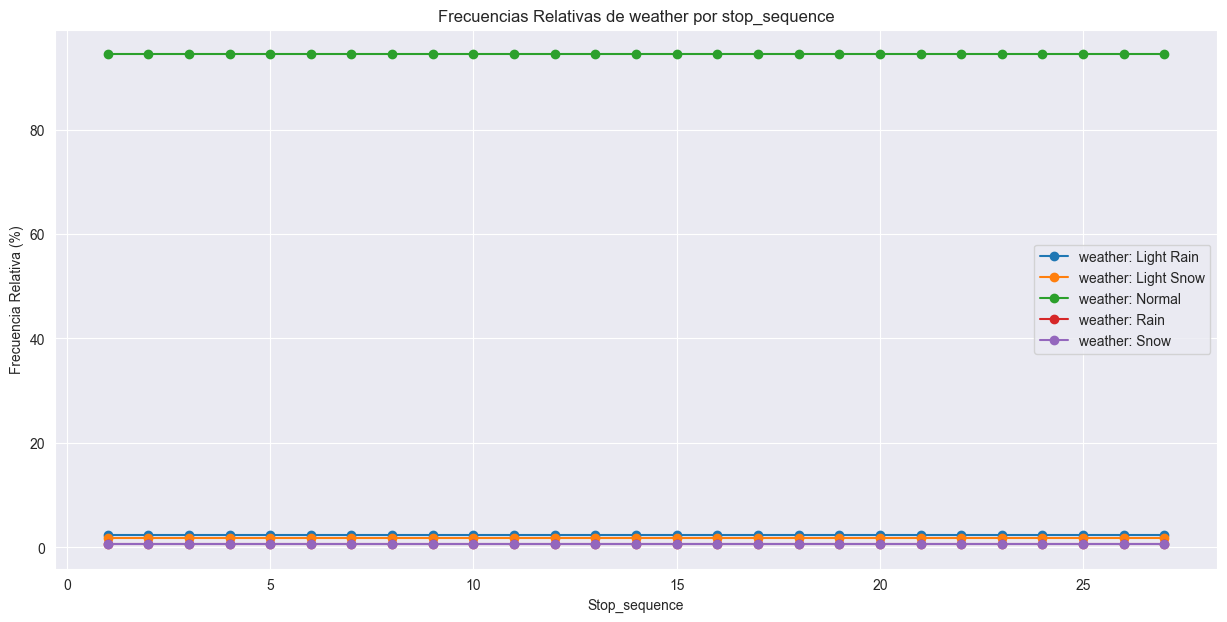

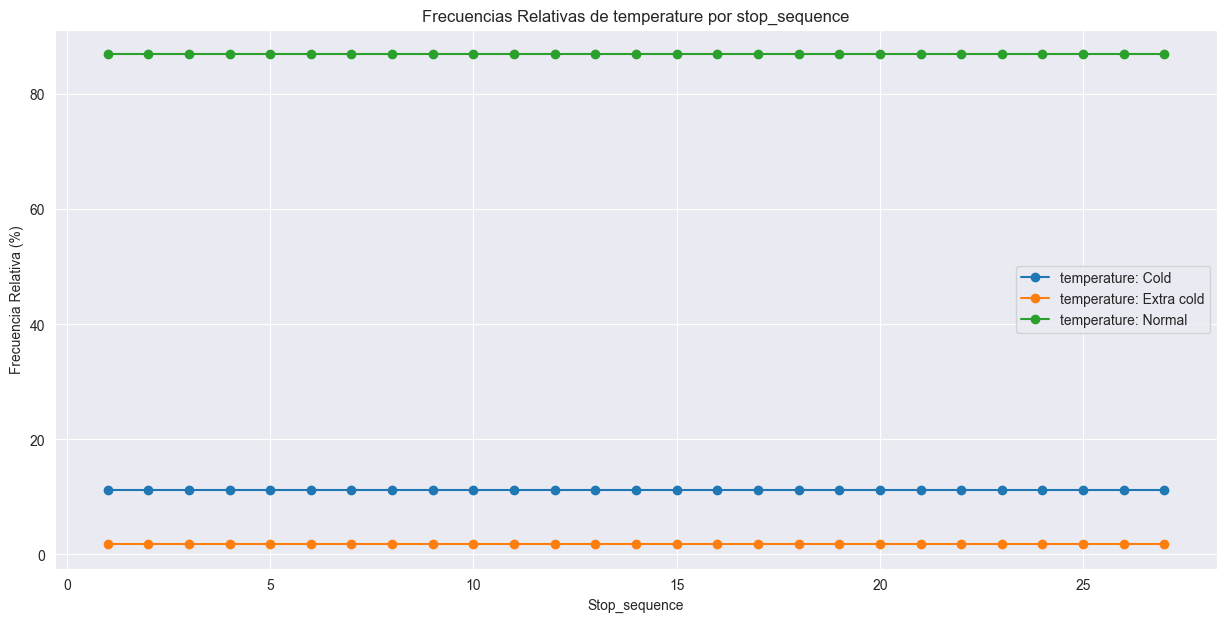

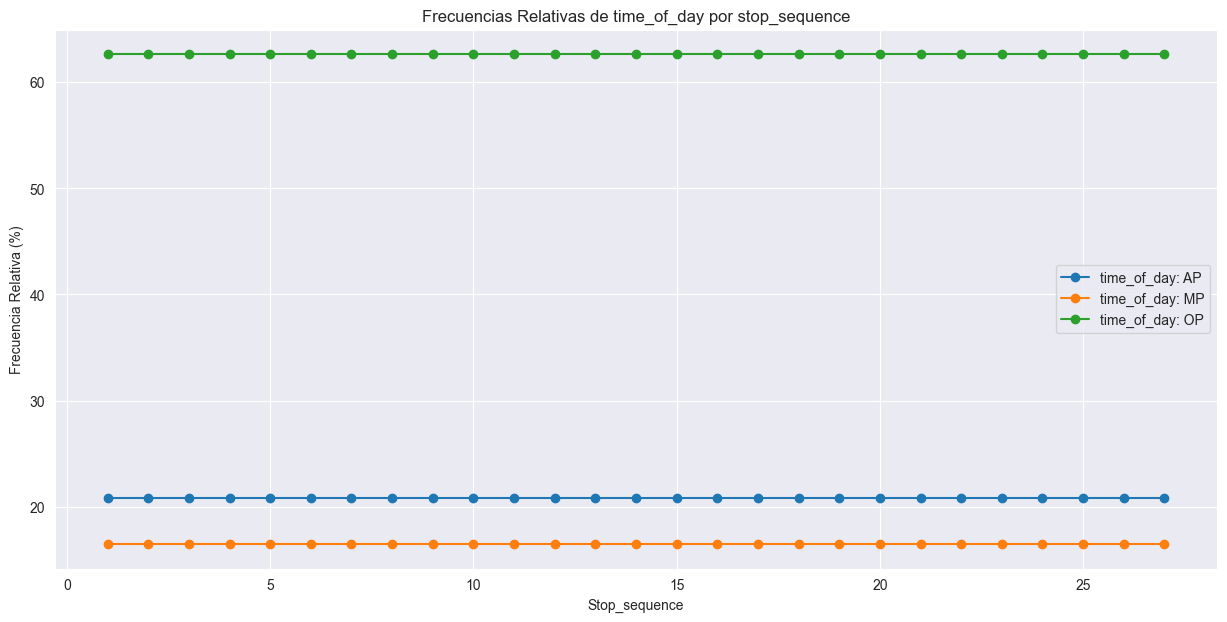

In [148]:
excluir_vars_categoricas = ['day_of_week']

# Filtrar las variables categóricas excluyendo las especificadas
variables_categoricas_filtradas = [col for col in variables_categoricas if col not in excluir_vars_categoricas]


def plot_frecuencias_categoricas_por_parada(df, cols_categoricas, group_by_col='stop_sequence'):
    # Calcular frecuencias relativas por grupo (stop_sequence)
    for col in cols_categoricas:
        # Calcular frecuencias absolutas y luego relativas
        abs_freq = df.groupby(group_by_col)[col].value_counts().unstack().fillna(0)
        rel_freq = abs_freq.div(abs_freq.sum(axis=1), axis=0) * 100

        # Configurar el tamaño de la figura
        plt.figure(figsize=(15, 7))

        # Crear gráfico para cada variable categórica
        for category in rel_freq.columns:
            plt.plot(rel_freq.index, rel_freq[category], marker='o', label=f'{col}: {category}')

        # Personalización del gráfico
        plt.title(f'Frecuencias Relativas de {col} por {group_by_col}')
        plt.xlabel(group_by_col.capitalize())
        plt.ylabel('Frecuencia Relativa (%)')
        plt.legend()
        plt.grid(True)

        # Mostrar el gráfico
        plt.show()


# Graficar las frecuencias relativas de las variables categóricas por parada
plot_frecuencias_categoricas_por_parada(df, variables_categoricas_filtradas)

# Plots Histogramas

## Histogramas Variables Continuas

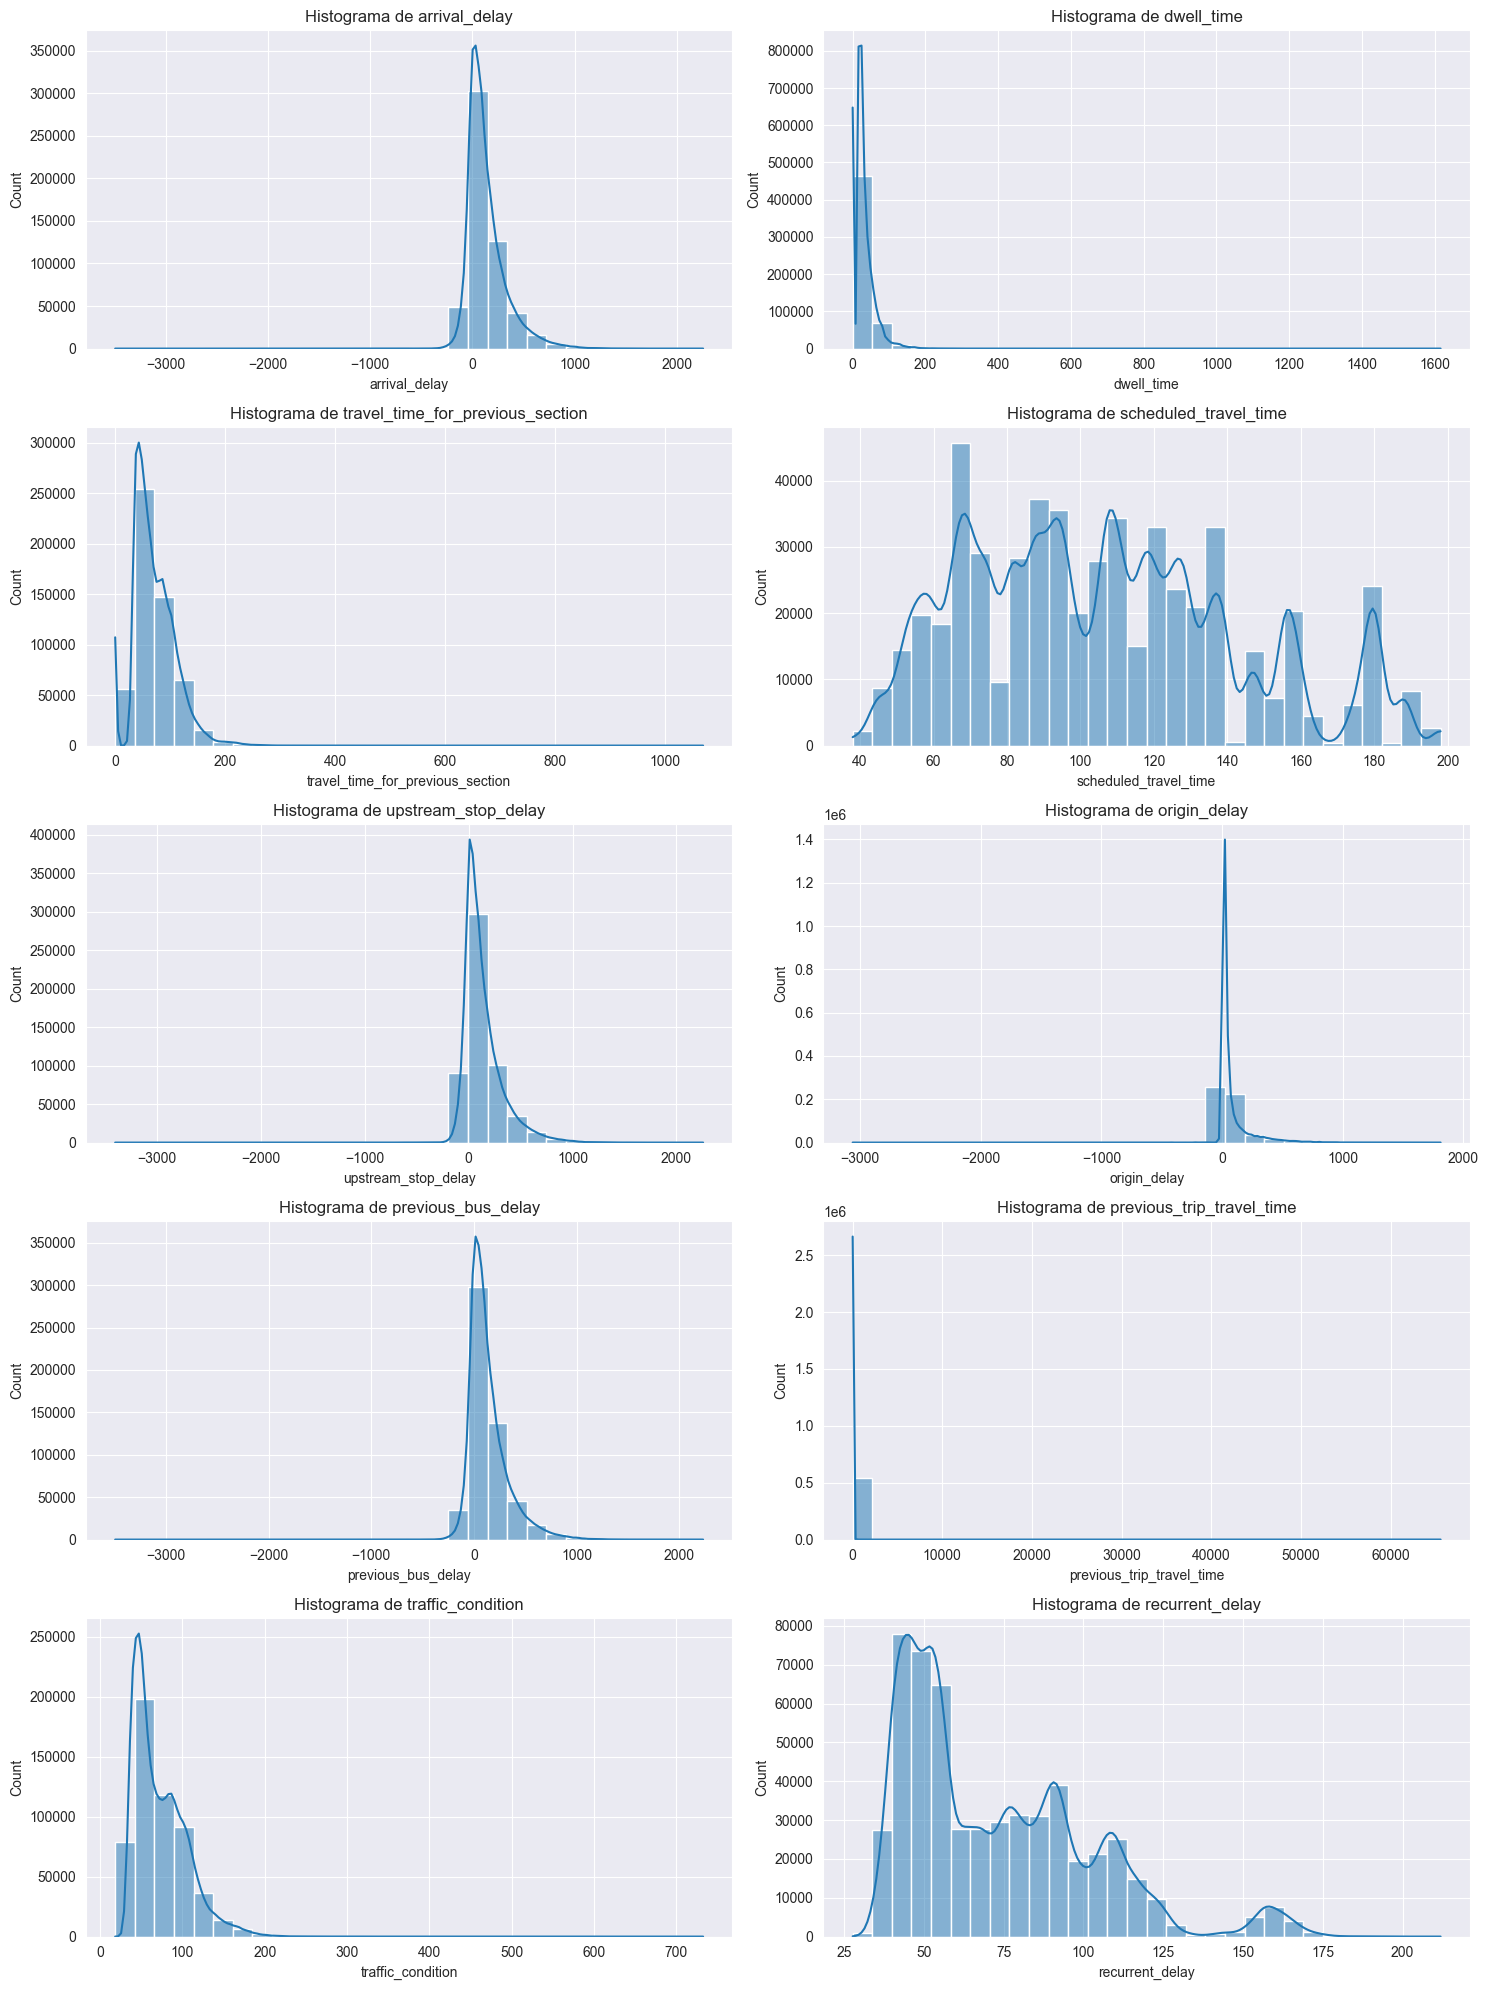

In [149]:
def plot_histogram(df, cols, bins=30):
    rows = (len(cols) + 1) // 2
    plt.figure(figsize=(15, rows * 4))
    for i, col in enumerate(cols, 1):
        plt.subplot(rows, 2, i)
        sns.histplot(df[col], kde=True, bins=bins)
        plt.title(f'Histograma de {col}')
    plt.tight_layout()
    plt.show()


numeric_cols = ['arrival_delay', 'dwell_time', 'travel_time_for_previous_section',
                'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
                'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
                'recurrent_delay']
plot_histogram(df, numeric_cols)

## Histogramas cruzados entre variables continuas

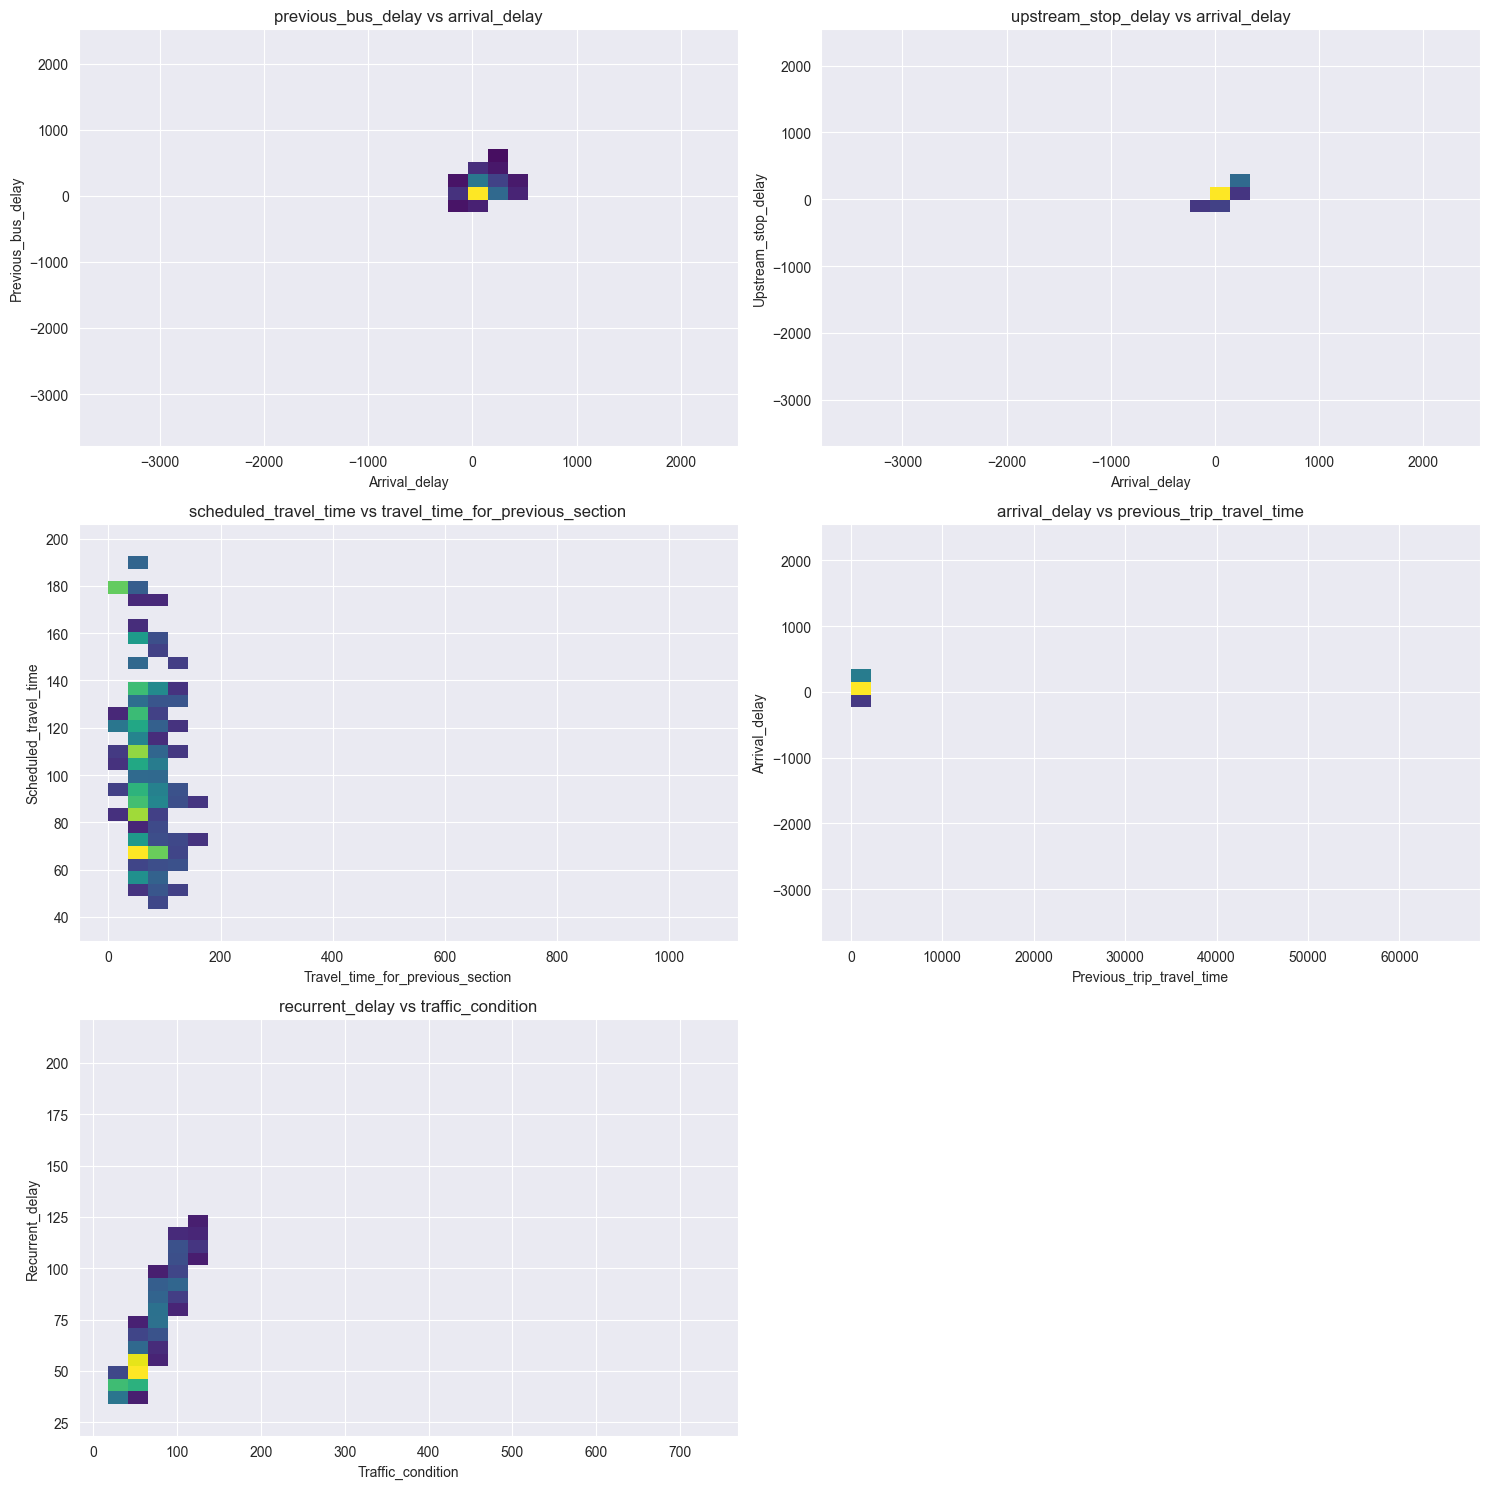

In [150]:
def plot_crossed_histograms_grid(df, pairs, bins=30):
    num_pairs = len(pairs)
    num_cols = 2
    num_rows = (num_pairs + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    # Graficar cada par de variables continuas en una grilla
    for i, (col_x, col_y) in enumerate(pairs, 1):
        plt.subplot(num_rows, num_cols, i)

        # Crear gráfico de dispersión (histograma bidimensional)
        sns.histplot(data=df, x=col_x, y=col_y, bins=bins, pthresh=.1, cmap="viridis")

        # Personalización del gráfico
        plt.title(f'{col_y} vs {col_x}')
        plt.xlabel(col_x.capitalize())
        plt.ylabel(col_y.capitalize())

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.show()


# Sugerir algunas combinaciones interesantes de variables continuas
pairs_continuas = [
    ('arrival_delay', 'previous_bus_delay'),
    ('arrival_delay', 'upstream_stop_delay'),
    ('travel_time_for_previous_section', 'scheduled_travel_time'),
    ('previous_trip_travel_time', 'arrival_delay'),
    ('traffic_condition', 'recurrent_delay')
]

# Graficar combinaciones cruzadas de variables continuas en una grilla
plot_crossed_histograms_grid(df, pairs_continuas)


## Histogramas cruzados entre Variables Continuas y Categóricas

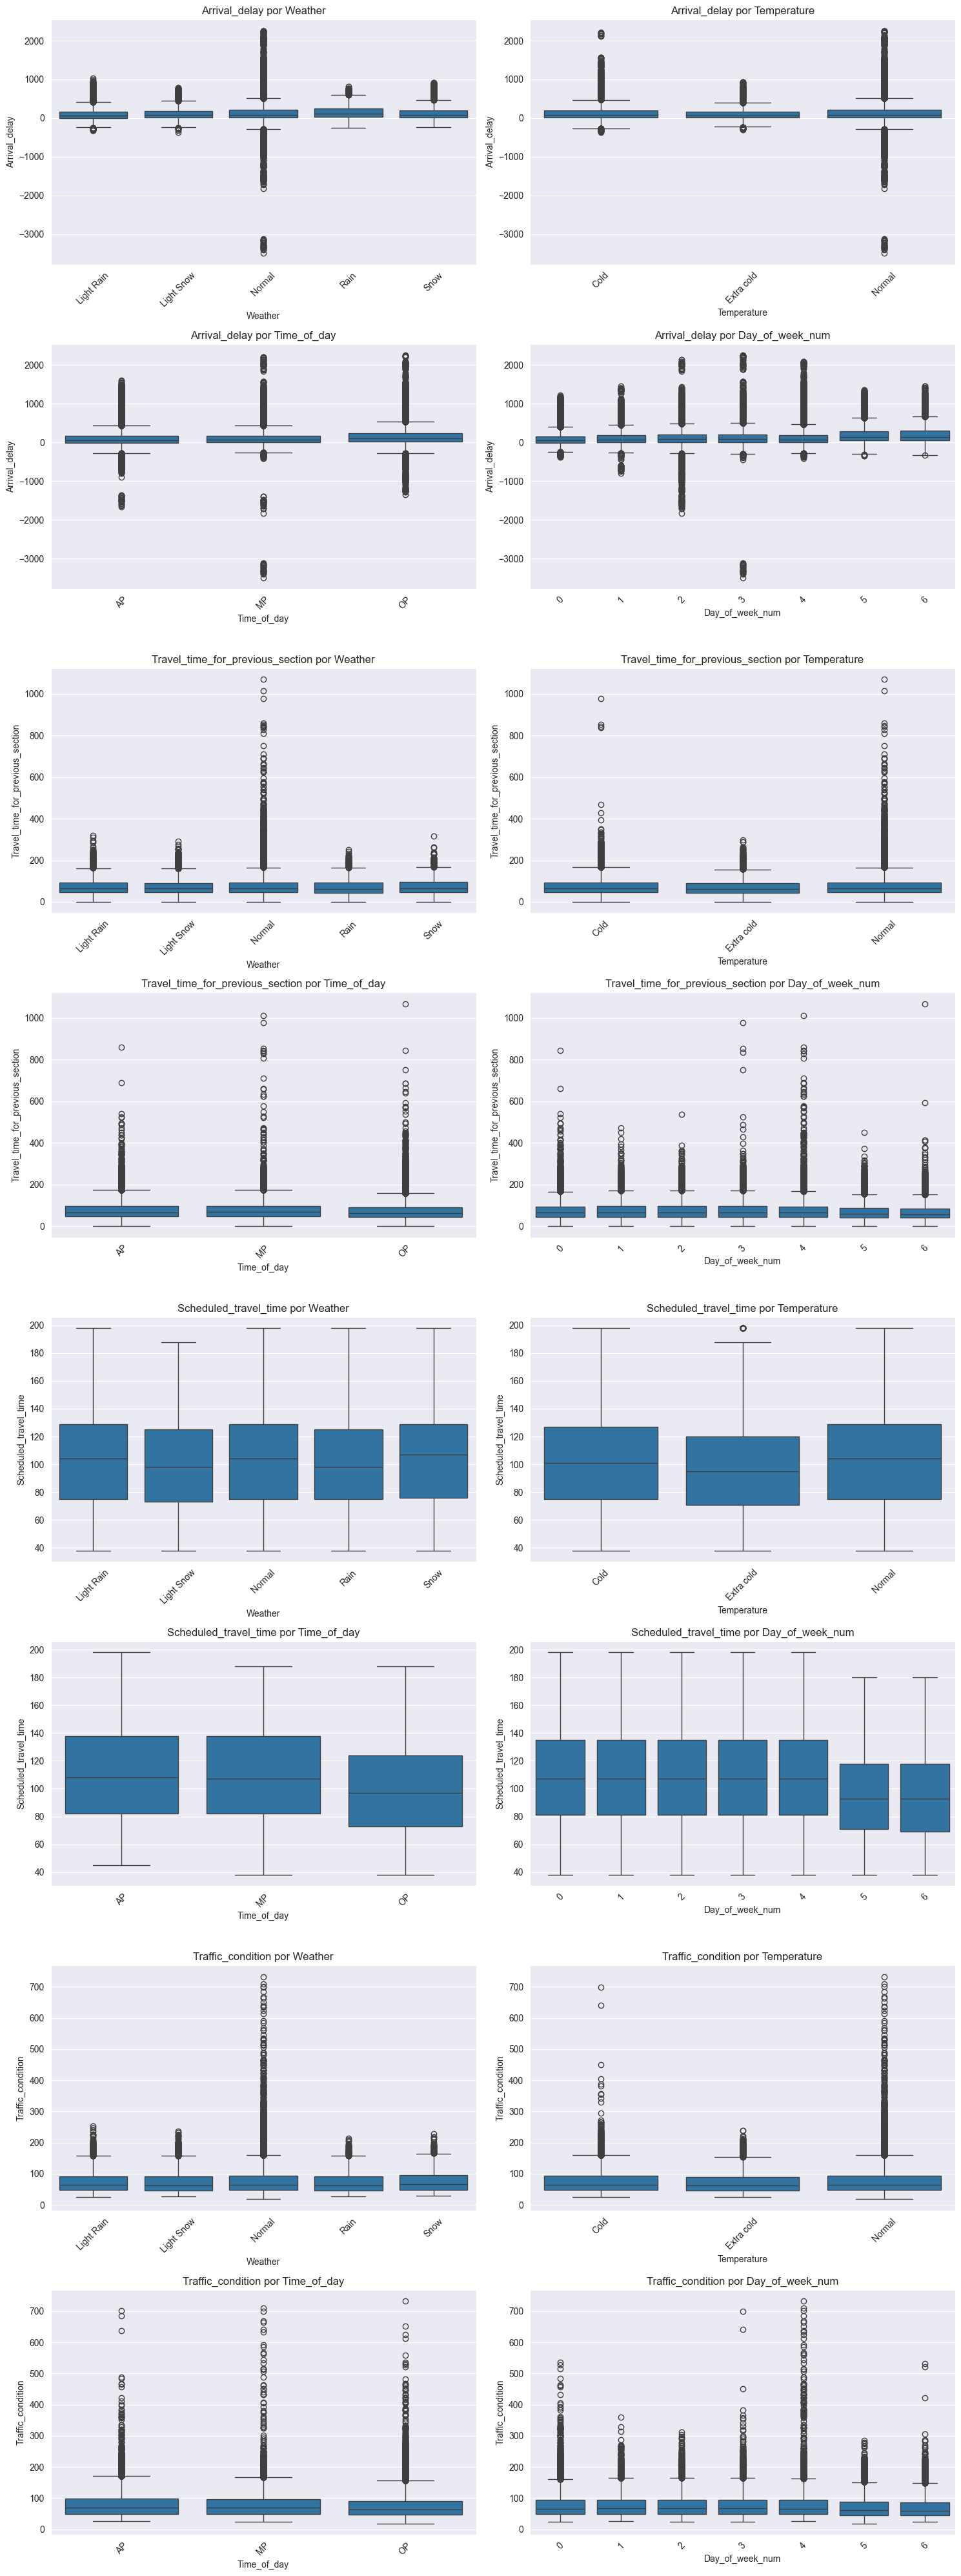

In [151]:
def plot_continuous_vs_categorical_grid(df, continuous_vars, categorical_vars):
    # Calcular el número total de gráficos y organizar en 2 columnas
    num_plots = len(continuous_vars) * len(categorical_vars)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    # Índice para la posición del gráfico en la grilla
    plot_idx = 1

    # Iterar por cada combinación de variable continua y categórica
    for col_cont in continuous_vars:
        for col_cat in categorical_vars:
            plt.subplot(num_rows, num_cols, plot_idx)
            plot_idx += 1

            # Crear boxplot de la variable continua por la variable categórica
            sns.boxplot(x=col_cat, y=col_cont, data=df)

            # Personalización del gráfico
            plt.title(f'{col_cont.capitalize()} por {col_cat.capitalize()}')
            plt.xlabel(col_cat.capitalize())
            plt.ylabel(col_cont.capitalize())
            plt.xticks(rotation=45)  # Rotar etiquetas si es necesario

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.show()


# Definir variables continuas y categóricas para cruzar
variables_continuas_interes = ['arrival_delay', 'travel_time_for_previous_section', 'scheduled_travel_time',
                               'traffic_condition']
variables_categoricas_interes = ['weather', 'temperature', 'time_of_day', 'day_of_week_num']

# Graficar combinaciones de variables continuas y categóricas en una grilla
plot_continuous_vs_categorical_grid(df, variables_continuas_interes, variables_categoricas_interes)


# Bar Charts

## Bar Chart Variables Categóricas

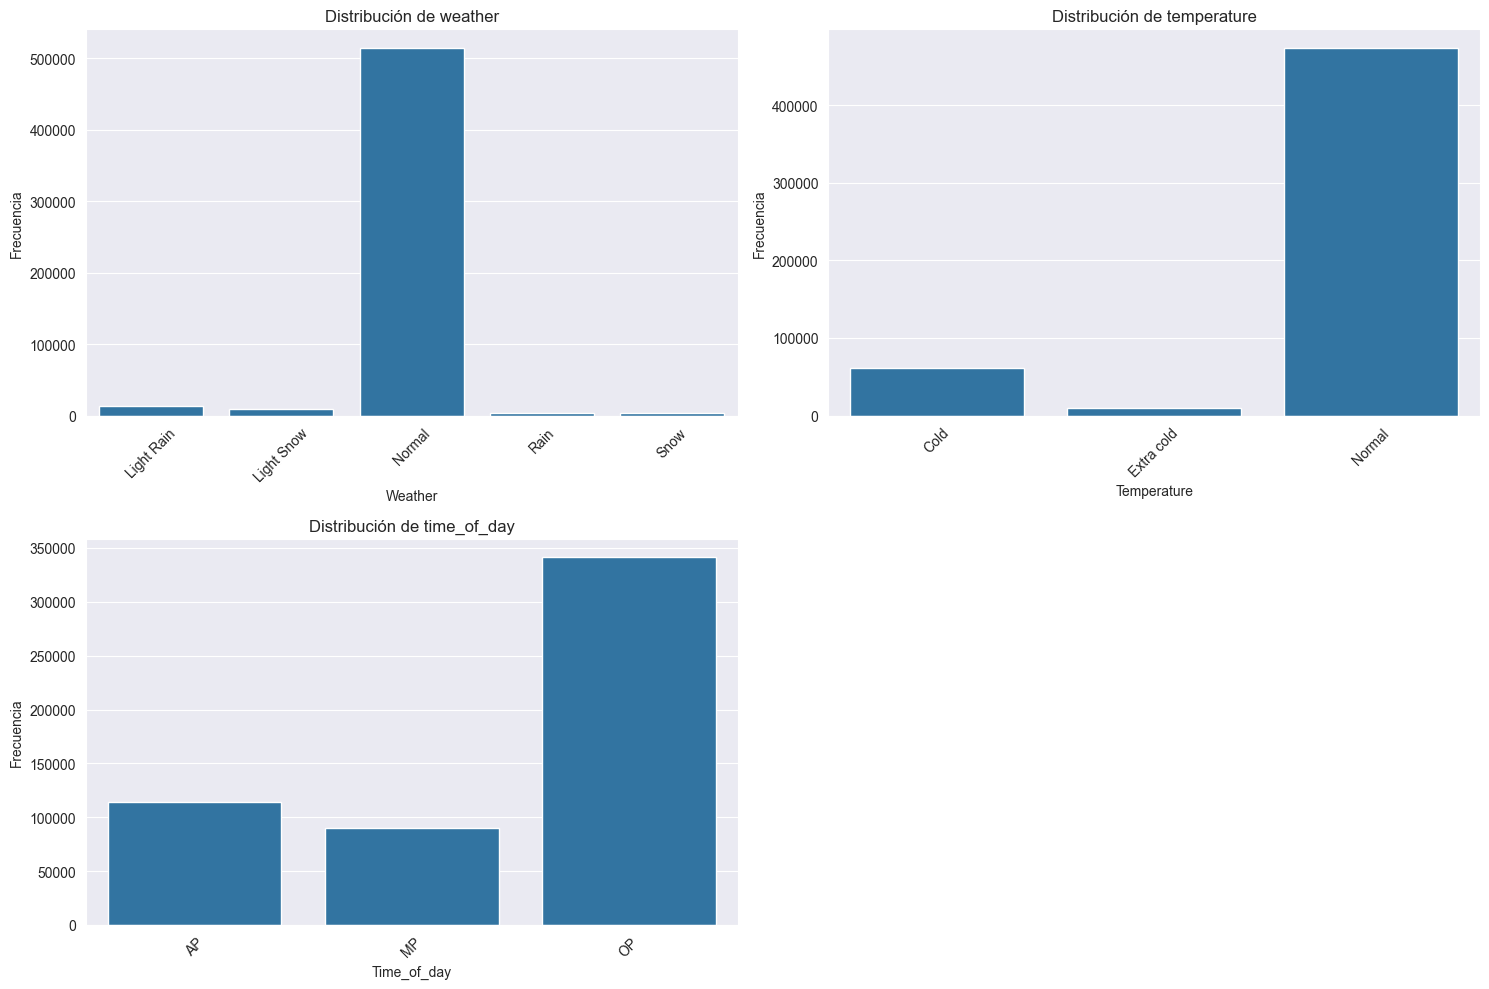

In [152]:
def plot_bar_categoricas(df, cols_categoricas):
    rows = (len(cols_categoricas) + 1) // 2
    plt.figure(figsize=(15, rows * 5))

    for i, col in enumerate(cols_categoricas, 1):
        plt.subplot(rows, 2, i)
        # Contar la frecuencia de cada categoría
        value_counts = df[col].value_counts()

        # Crear el gráfico de barras
        sns.barplot(x=value_counts.index, y=value_counts.values)

        # Personalización del gráfico
        plt.title(f'Distribución de {col}')
        plt.xlabel(col.capitalize())
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)  # Rotar las etiquetas si es necesario

    plt.tight_layout()
    plt.show()


# Definir variables categóricas a graficar
variables_categoricas = ['weather', 'temperature', 'time_of_day']

# Graficar distribución de frecuencias de variables categóricas
plot_bar_categoricas(df, variables_categoricas)

# Box plots

## Box plots Variables Continuas

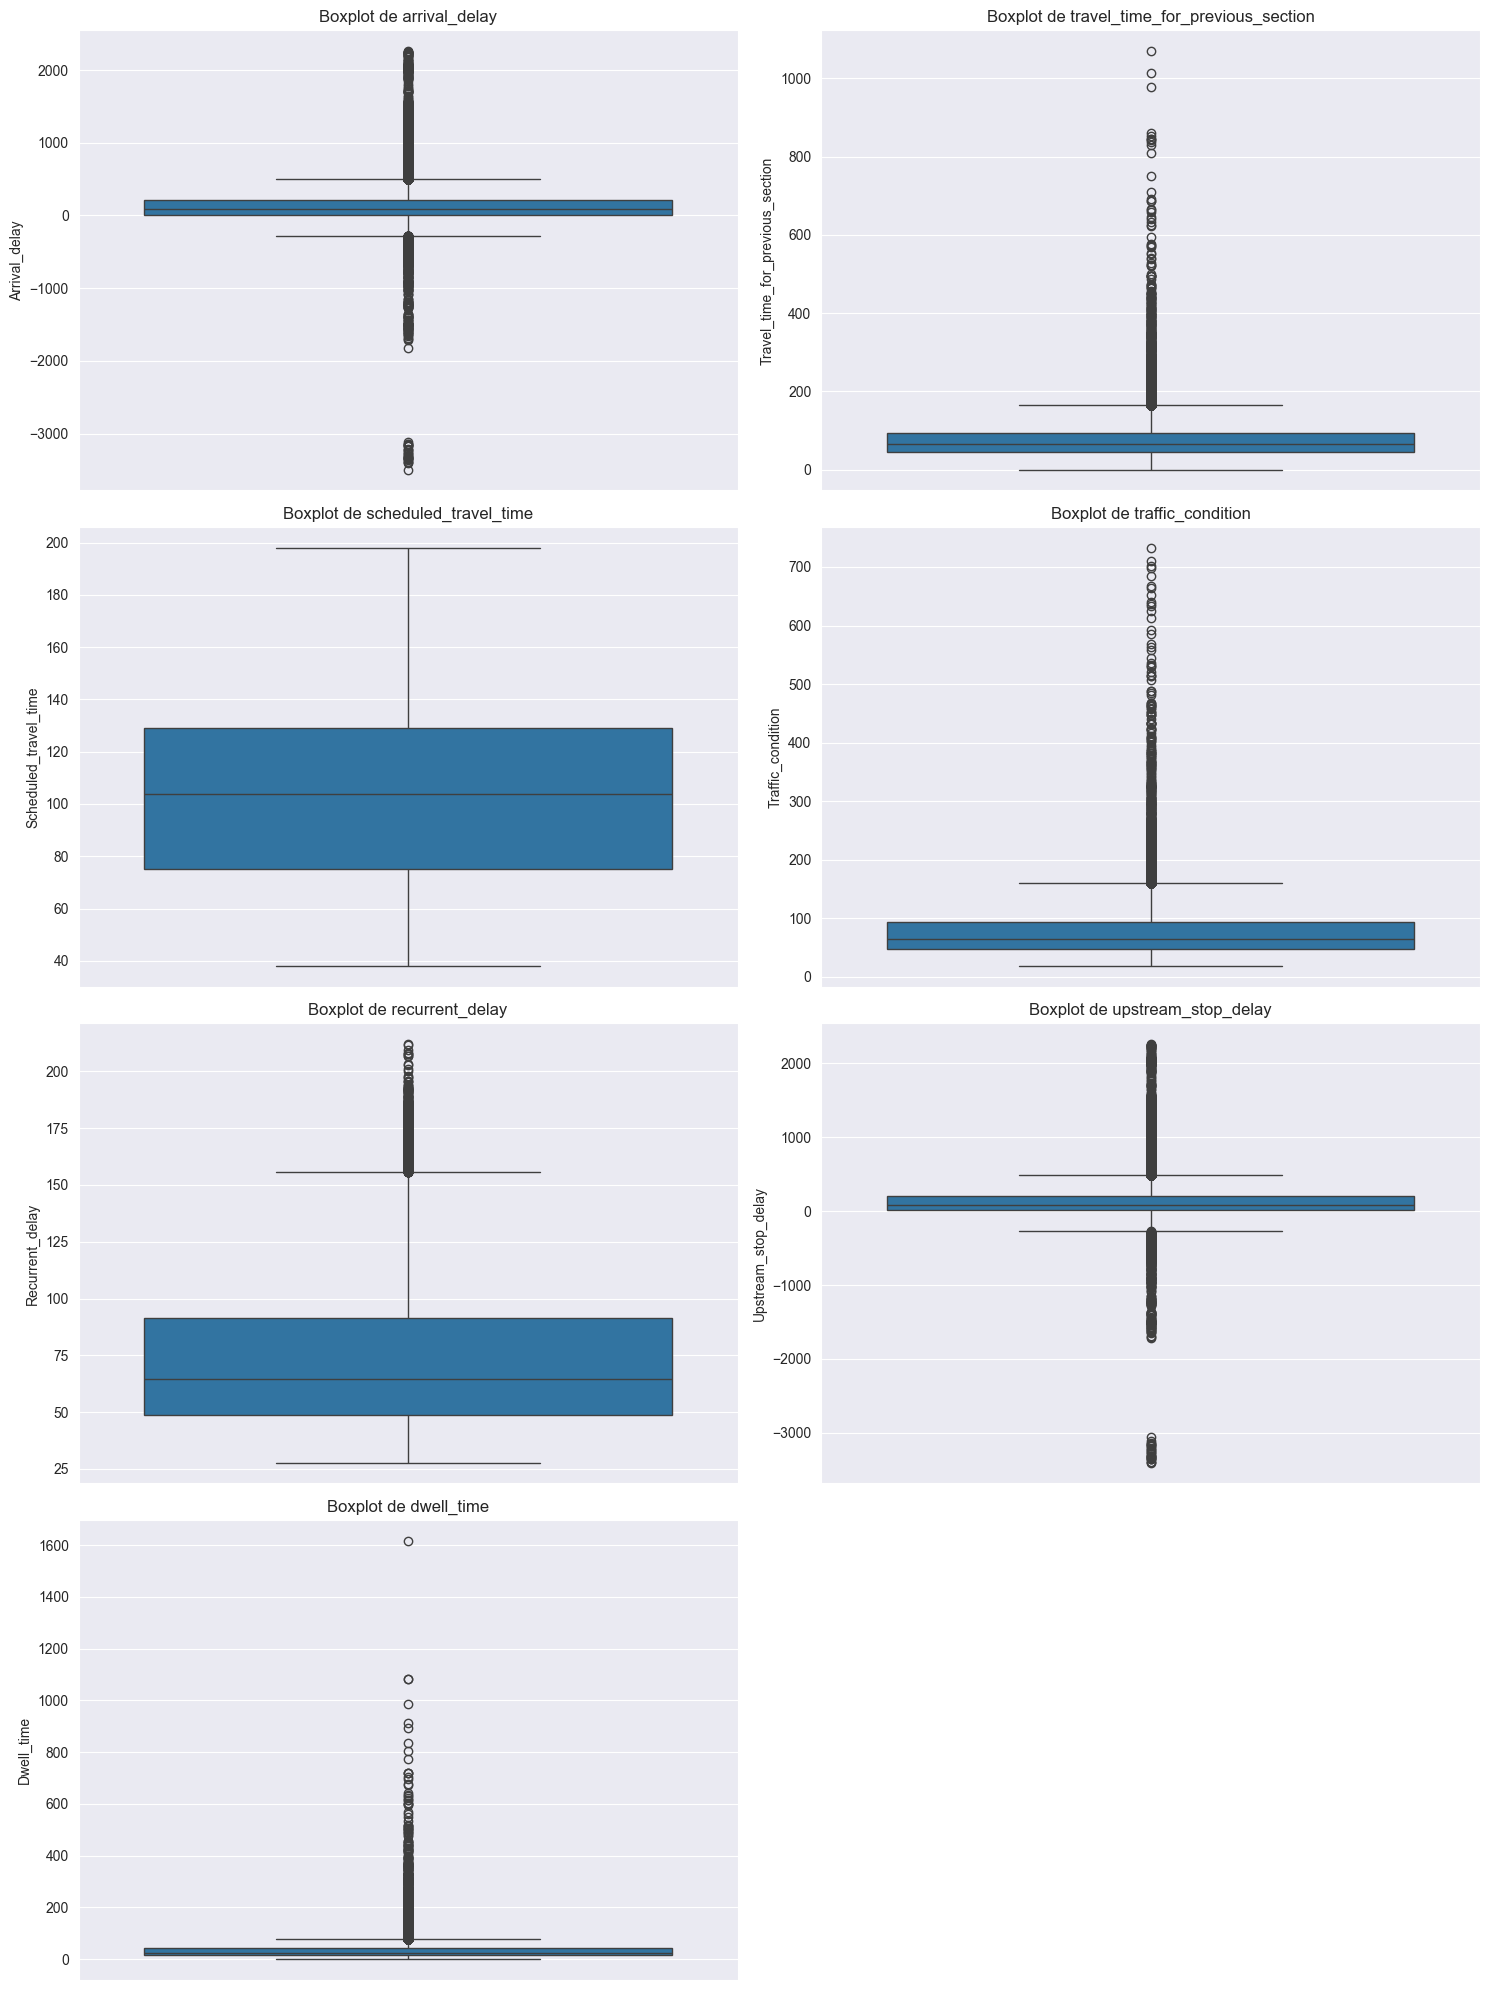

In [153]:
def plot_boxplots_continuous(df, continuous_vars):
    # Calcular el número total de variables y organizar en 2 columnas
    num_vars = len(continuous_vars)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    # Graficar cada variable continua
    for i, col in enumerate(continuous_vars, 1):
        plt.subplot(num_rows, num_cols, i)

        # Crear boxplot de la variable continua
        sns.boxplot(data=df, y=col)

        # Personalización del gráfico
        plt.title(f'Boxplot de {col}')
        plt.ylabel(col.capitalize())

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.show()


# Definir las variables continuas para graficar
variables_continuas = ['arrival_delay', 'travel_time_for_previous_section', 'scheduled_travel_time',
                       'traffic_condition', 'recurrent_delay', 'upstream_stop_delay', 'dwell_time']

# Graficar boxplots de las variables continuas
plot_boxplots_continuous(df, variables_continuas)

# Outliers

In [154]:
from scipy import stats


def eliminar_outliers_multiple(df, cols, threshold=3):
    rows_initial = df.shape[0]  # Número de filas inicial
    eliminados_totales = pd.Series(0, index=cols)  # Serie para contar filas eliminadas por cada columna

    # Iterar sobre cada columna y eliminar outliers
    for col in cols:
        z_scores = stats.zscore(df[col])
        abs_z_scores = np.abs(z_scores)
        is_not_outlier = abs_z_scores <= threshold

        # Contar filas eliminadas
        eliminados_totales[col] = rows_initial - is_not_outlier.sum()

        # Filtrar el DataFrame para la columna actual
        df = df[is_not_outlier]

    # Calcular el total de filas después de eliminar outliers
    rows_final = df.shape[0]
    eliminados_totales_absolutos = rows_initial - rows_final

    # Calcular porcentajes de eliminación
    eliminados_porcentaje = (eliminados_totales / rows_initial) * 100
    eliminados_totales_porcentaje = (eliminados_totales_absolutos / rows_initial) * 100

    # Imprimir estadísticas de eliminación por columna
    print("\n### Estadísticas de Eliminación de Outliers ###\n")
    print(f"Total de filas iniciales: {rows_initial}")
    print(f"Total de filas finales: {rows_final}")
    print(f"Total de filas eliminadas: {eliminados_totales_absolutos} ({eliminados_totales_porcentaje:.2f}%)")
    print("\nFilas eliminadas por columna:")
    for col in cols:
        print(f" - {col}: {eliminados_totales[col]} eliminadas ({eliminados_porcentaje[col]:.2f}%)")

    return df


# Definir variables continuas para las cuales eliminar outliers
'''
variables_continuas = ['arrival_delay', 'travel_time_for_previous_section', 'scheduled_travel_time',
                       'traffic_condition', 'recurrent_delay', 'upstream_stop_delay', 'dwell_time']
'''
variables_continuas = ['arrival_delay', 'dwell_time']

# Eliminar outliers de múltiples columnas
df_cleaned_multiple = eliminar_outliers_multiple(df, variables_continuas)


### Estadísticas de Eliminación de Outliers ###

Total de filas iniciales: 545103
Total de filas finales: 525632
Total de filas eliminadas: 19471 (3.57%)

Filas eliminadas por columna:
 - arrival_delay: 9447 eliminadas (1.73%)
 - dwell_time: 19471 eliminadas (3.57%)


In [155]:
# Exportar el DataFrame limpio como un archivo CSV
output_path = "data/Dataset-PT_no_sample.csv"
df_cleaned_multiple.to_csv(output_path, index=False)

print(f"El DataFrame ha sido exportado exitosamente a {output_path}")

El DataFrame ha sido exportado exitosamente a data/Dataset-PT_no_sample.csv


# Sub Sampling

## Stratified sample

In [156]:
df_sorted = df_cleaned_multiple.sort_values('Calendar_date')
df_time_sampled = df_sorted.iloc[::10, :].reset_index(drop=True)

df_train, df_stratified = train_test_split(
    df_time_sampled,
    test_size=0.1,
    stratify=df_time_sampled['day_of_week'],
    random_state=42
)

In [157]:
# Exportar el DataFrame limpio como un archivo CSV
output_path = "data/Dataset-PT_stratified.csv"
df_stratified.to_csv(output_path, index=False)

print(f"El DataFrame ha sido exportado exitosamente a {output_path}")

El DataFrame ha sido exportado exitosamente a data/Dataset-PT_stratified.csv


## KMeans Sample

In [158]:
from sklearn.cluster import KMeans

def submuestreo_kmeans(df, columns_to_exclude, n_clusters=10, sample_percentage=0.01):
    # Excluir columnas específicas
    df_filtered = df.drop(columns=columns_to_exclude)

    # Separar características (X) y variable objetivo (y)
    X = df_filtered.drop(['arrival_delay'], axis=1)
    y = df_filtered['arrival_delay']
    
    # Determinar el número total de filas para calcular el tamaño de muestra por cluster
    total_rows = X.shape[0]
    
    # Calcular el número de muestras por cluster como 1% del total de filas
    n_samples_per_cluster = int(sample_percentage * total_rows / n_clusters)

    # Aplicar KMeans clustering usando las columnas filtradas
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    df['cluster'] = clusters

    # Muestrear un porcentaje de cada cluster
    # Muestrear un porcentaje de cada cluster, respetando el tamaño máximo de cada cluster
    df_kmeans_sampled = df.groupby('cluster', group_keys=False).apply(
    lambda x: x.sample(
        n=n_samples_per_cluster,  # Tomar siempre el tamaño calculado
        replace=True,  # Permitir reemplazo si hay menos filas en el cluster
        random_state=42
    )
).reset_index(drop=True)

    return df_kmeans_sampled

# Definir columnas a excluir para KMeans
columns_to_drop = ['Calendar_date', 'route_id', 'bus_id', 'weather', 'temperature', 'day_of_week', 'time_of_day']

# Aplicar KMeans para el muestreo basado en el 1% del total de filas
df_kmeans_sampled = submuestreo_kmeans(df_cleaned_multiple, columns_to_drop)
df_kmeans_sampled = df_kmeans_sampled.drop(columns=['cluster'])

C:\Users\jecla\AppData\Local\Temp\ipykernel_35400\1279590132.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kmeans_sampled = df.groupby('cluster', group_keys=False).apply(


In [159]:
# Exportar el DataFrame limpio como un archivo CSV
output_path = "data/Dataset-PT_KMeans.csv"
df_kmeans_sampled.to_csv(output_path, index=False)

print(f"El DataFrame ha sido exportado exitosamente a {output_path}")

El DataFrame ha sido exportado exitosamente a data/Dataset-PT_KMeans.csv


# Plots Original Vs. KMeans Distribution

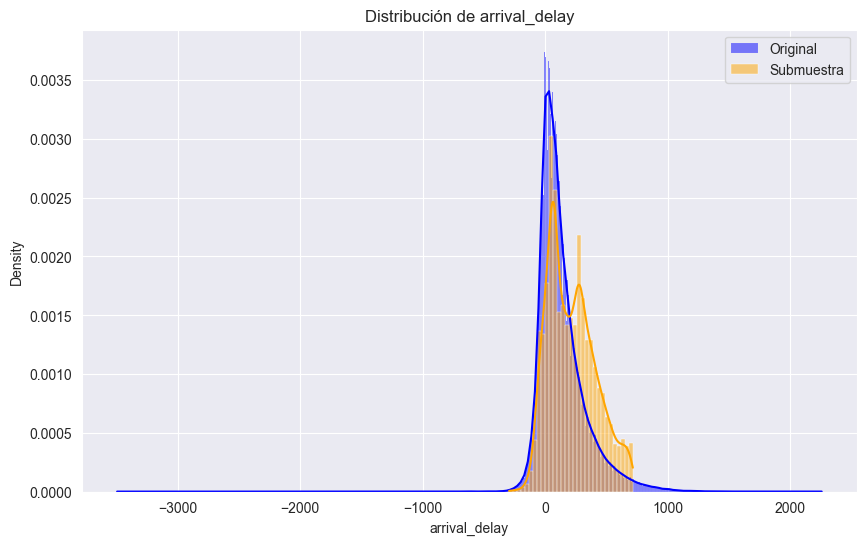

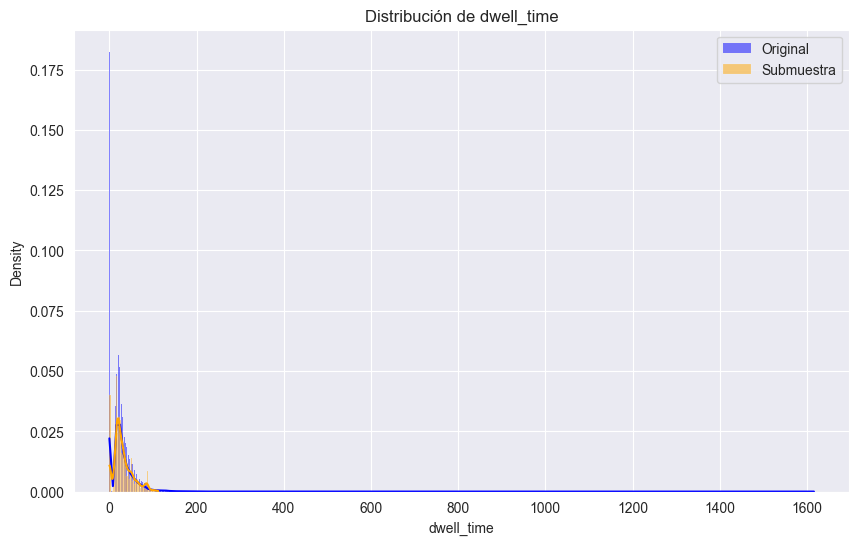

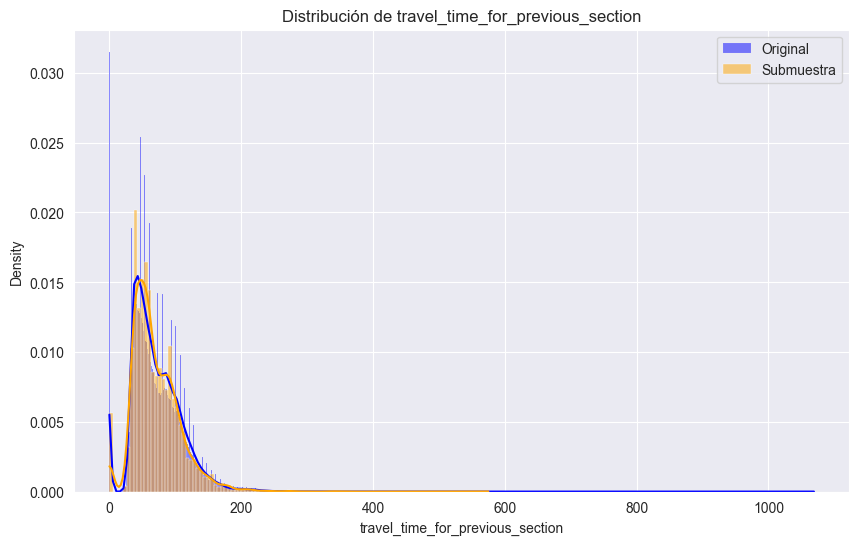

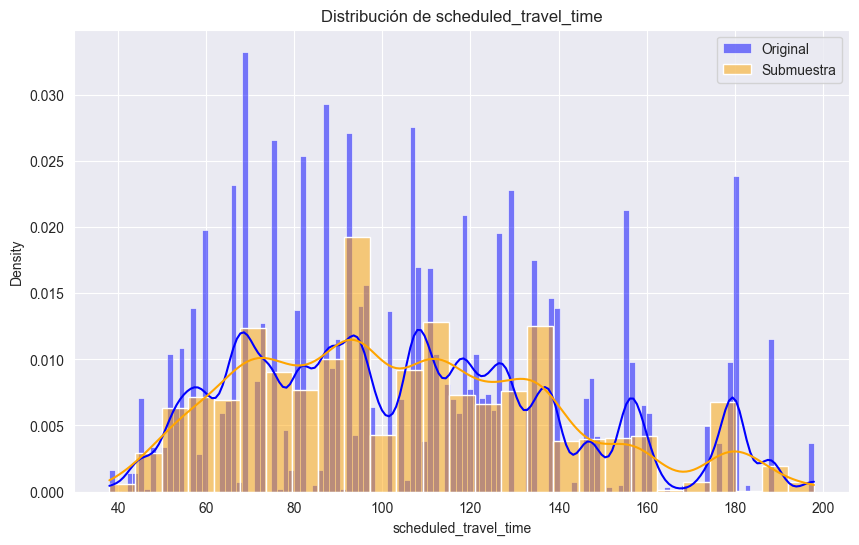

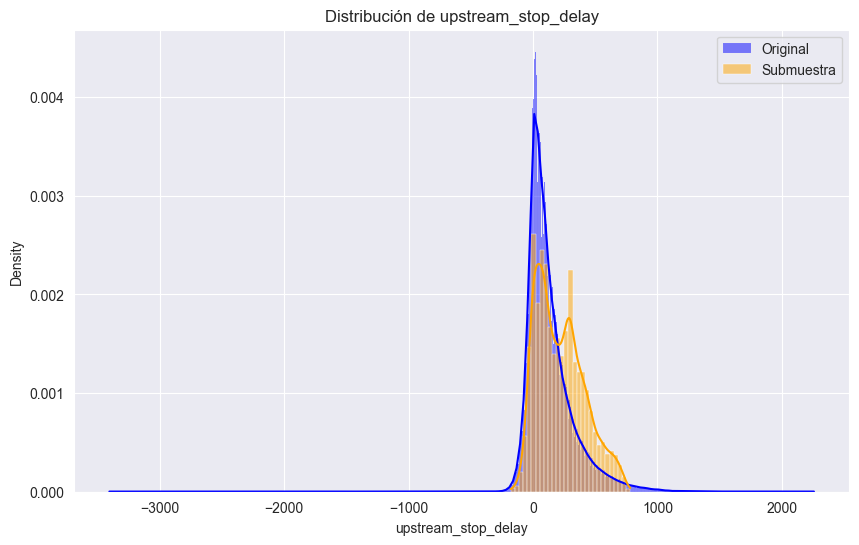

C:\Users\jecla\Documents\PT_AI_Proyect\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


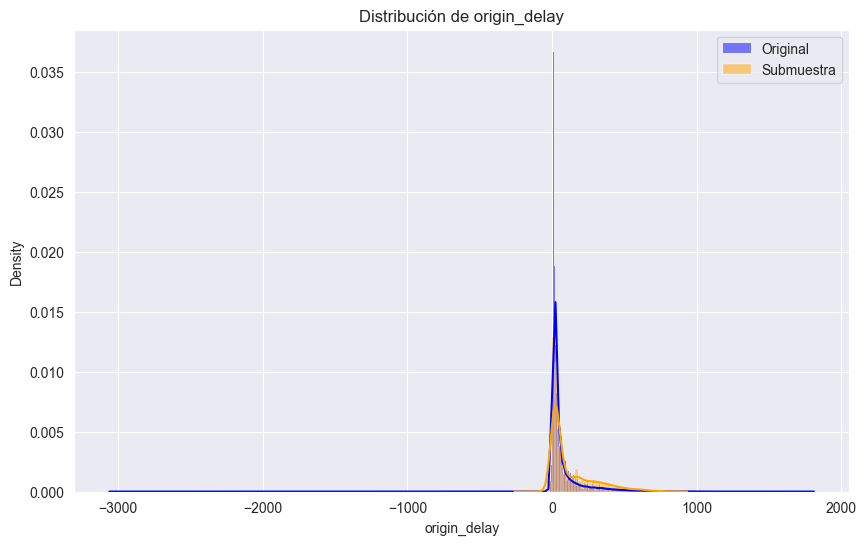

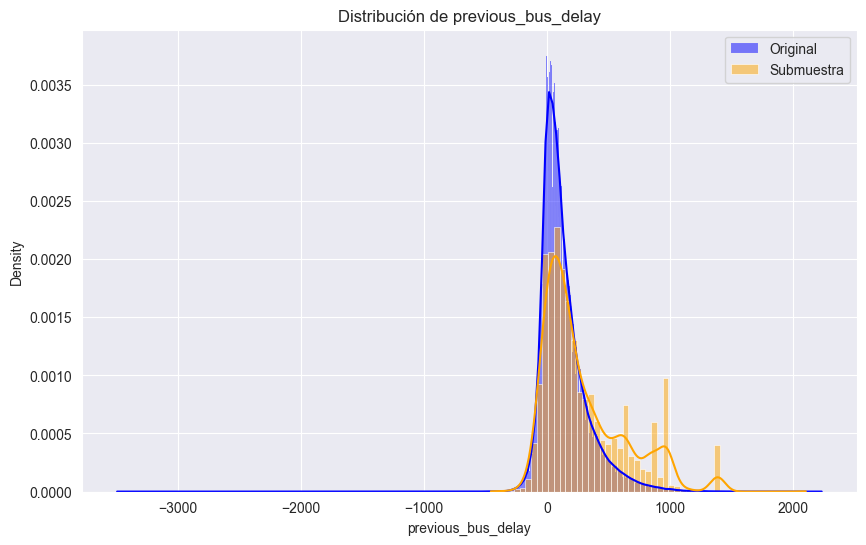

C:\Users\jecla\Documents\PT_AI_Proyect\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


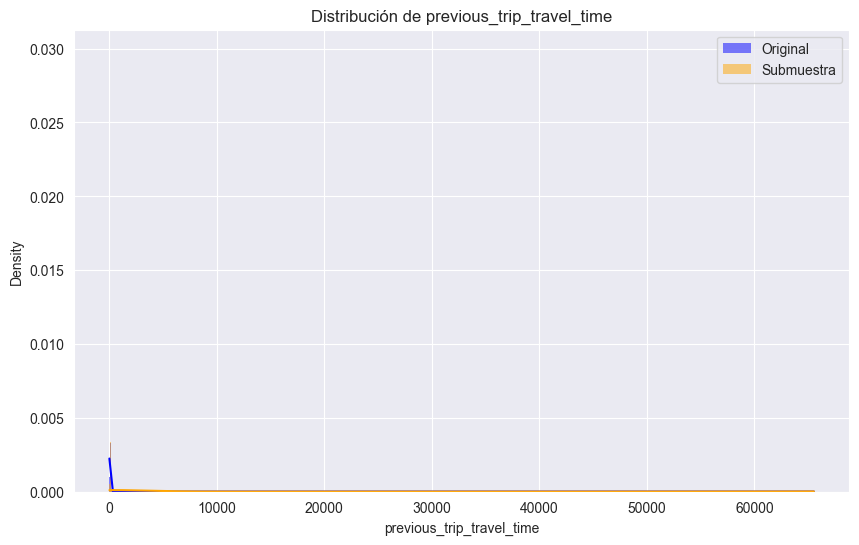

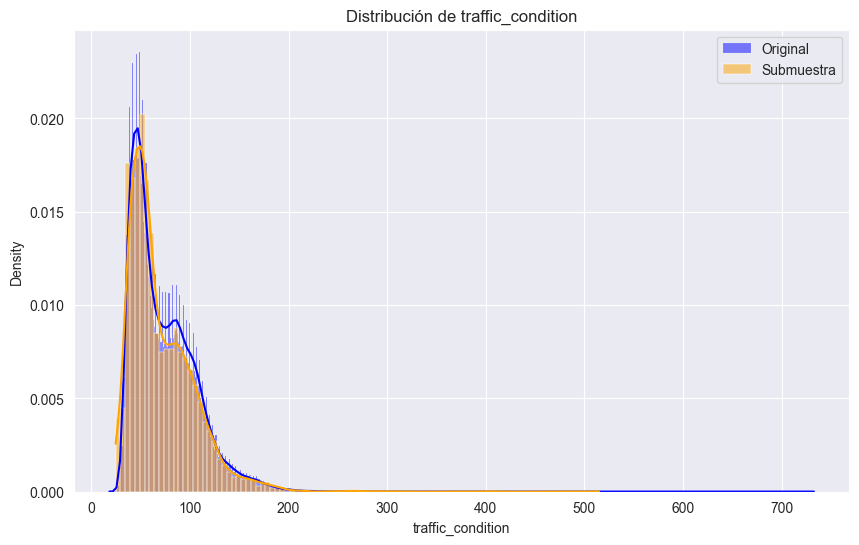

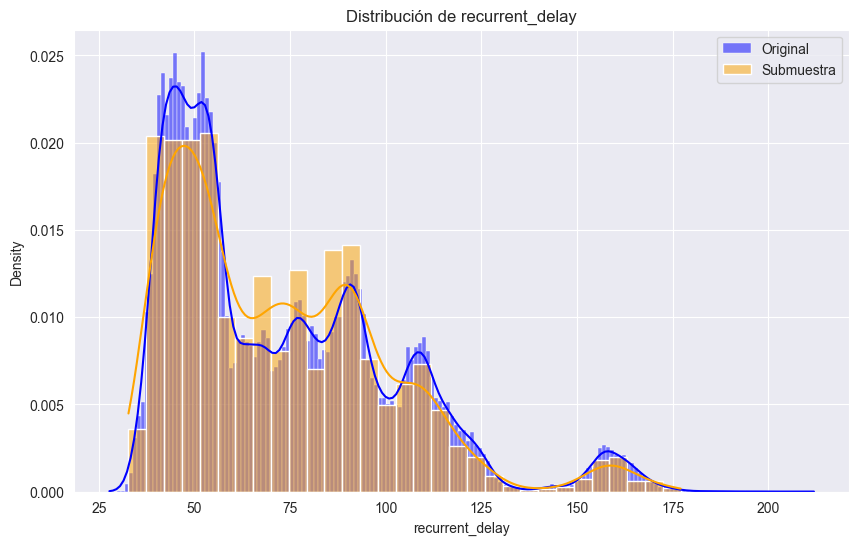

In [160]:
def plot_distributions(df_original, df_sampled, cols):
    for col in cols:
        plt.figure(figsize=(10, 6))
        sns.histplot(df_original[col], color='blue', label='Original', kde=True, stat="density")
        sns.histplot(df_sampled[col], color='orange', label='Submuestra', kde=True, stat="density")
        plt.title(f'Distribución de {col}')
        plt.legend()
        plt.show()

plot_distributions(df, df_kmeans_sampled, numeric_cols)

# Comparaciones estadísticas

## Comparación estadística

In [161]:
def comparar_estadisticas(df_original, df_sampled, numeric_cols, threshold=0.05):
    original_summary = df_original[numeric_cols].describe()
    sampled_summary = df_sampled[numeric_cols].describe()

    print("\n### Comparación de Estadísticas ###")
    for col in numeric_cols:
        mean_diff = np.abs(original_summary.loc['mean', col] - sampled_summary.loc['mean', col]) / original_summary.loc[
            'mean', col]
        print(f"{col} - Diferencia de Medias: {mean_diff:.2%} (Umbral: {threshold * 100}%)")

        # Otras comparaciones de medianas y desviaciones estándar pueden agregarse aquí

In [162]:
comparar_estadisticas(df, df_stratified, numeric_cols)


### Comparación de Estadísticas ###
arrival_delay - Diferencia de Medias: 8.75% (Umbral: 5.0%)
dwell_time - Diferencia de Medias: 6.56% (Umbral: 5.0%)
travel_time_for_previous_section - Diferencia de Medias: 1.22% (Umbral: 5.0%)
scheduled_travel_time - Diferencia de Medias: 0.72% (Umbral: 5.0%)
upstream_stop_delay - Diferencia de Medias: 7.24% (Umbral: 5.0%)
origin_delay - Diferencia de Medias: 9.65% (Umbral: 5.0%)
previous_bus_delay - Diferencia de Medias: 1.85% (Umbral: 5.0%)
previous_trip_travel_time - Diferencia de Medias: 1.55% (Umbral: 5.0%)
traffic_condition - Diferencia de Medias: 0.72% (Umbral: 5.0%)
recurrent_delay - Diferencia de Medias: 0.56% (Umbral: 5.0%)


In [163]:
comparar_estadisticas(df, df_kmeans_sampled, numeric_cols)


### Comparación de Estadísticas ###
arrival_delay - Diferencia de Medias: 61.85% (Umbral: 5.0%)
dwell_time - Diferencia de Medias: 4.36% (Umbral: 5.0%)
travel_time_for_previous_section - Diferencia de Medias: 1.57% (Umbral: 5.0%)
scheduled_travel_time - Diferencia de Medias: 0.94% (Umbral: 5.0%)
upstream_stop_delay - Diferencia de Medias: 62.83% (Umbral: 5.0%)
origin_delay - Diferencia de Medias: 70.37% (Umbral: 5.0%)
previous_bus_delay - Diferencia de Medias: 116.73% (Umbral: 5.0%)
previous_trip_travel_time - Diferencia de Medias: 8871.16% (Umbral: 5.0%)
traffic_condition - Diferencia de Medias: 3.84% (Umbral: 5.0%)
recurrent_delay - Diferencia de Medias: 0.92% (Umbral: 5.0%)


## T-test

In [164]:
def prueba_t_test(df_original, df_sampled, cols, alpha=0.05):
    print("\n### T-tests ###")
    for col in cols:
        t_stat, p_value = ttest_ind(df_original[col], df_sampled[col])
        resultado = "Significativa" if p_value < alpha else "No significativa"
        print(f"{col} - p-value: {p_value:.3f} ({resultado})")

In [165]:
prueba_t_test(df, df_stratified, numeric_cols)


### T-tests ###
arrival_delay - p-value: 0.000 (Significativa)
dwell_time - p-value: 0.000 (Significativa)
travel_time_for_previous_section - p-value: 0.094 (No significativa)
scheduled_travel_time - p-value: 0.129 (No significativa)
upstream_stop_delay - p-value: 0.000 (Significativa)
origin_delay - p-value: 0.000 (Significativa)
previous_bus_delay - p-value: 0.354 (No significativa)
previous_trip_travel_time - p-value: 0.680 (No significativa)
traffic_condition - p-value: 0.243 (No significativa)
recurrent_delay - p-value: 0.322 (No significativa)


In [166]:
prueba_t_test(df, df_kmeans_sampled, numeric_cols)


### T-tests ###
arrival_delay - p-value: 0.000 (Significativa)
dwell_time - p-value: 0.000 (Significativa)
travel_time_for_previous_section - p-value: 0.032 (Significativa)
scheduled_travel_time - p-value: 0.049 (Significativa)
upstream_stop_delay - p-value: 0.000 (Significativa)
origin_delay - p-value: 0.000 (Significativa)
previous_bus_delay - p-value: 0.000 (Significativa)
previous_trip_travel_time - p-value: 0.000 (Significativa)
traffic_condition - p-value: 0.000 (Significativa)
recurrent_delay - p-value: 0.101 (No significativa)


## Chi-square

In [167]:
def prueba_chi_square(df_original, df_sampled, dummy_vars, alpha=0.05):
    print("\n### Chi-Square Tests ###")
    for var in dummy_vars:
        contingency_table = pd.crosstab(df_original[var], df_sampled[var])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        resultado = "Significativa" if p_value < alpha else "No significativa"
        print(f"{var} - p-value: {p_value:.3f} ({resultado})")

In [168]:
prueba_chi_square(df, df_stratified, dummy_vars)


### Chi-Square Tests ###
factor(weather)Light_Rain - p-value: 0.301 (No significativa)
factor(weather)Light_Snow - p-value: 0.677 (No significativa)
factor(weather)Normal - p-value: 0.064 (No significativa)
factor(weather)Rain - p-value: 1.000 (No significativa)
factor(weather)Snow - p-value: 1.000 (No significativa)
factor(temperature)Cold - p-value: 0.001 (Significativa)
factor(temperature)Extra_cold - p-value: 0.347 (No significativa)
factor(temperature)Normal - p-value: 0.000 (Significativa)
factor(day_of_week)weekday - p-value: 0.000 (Significativa)
factor(day_of_week)weekend - p-value: 0.000 (Significativa)
factor(time_of_day)Afternoon_peak - p-value: 0.119 (No significativa)
factor(time_of_day)Morning_peak - p-value: 0.593 (No significativa)
factor(time_of_day)Off-peak - p-value: 0.000 (Significativa)


In [169]:
prueba_chi_square(df, df_kmeans_sampled, dummy_vars)


### Chi-Square Tests ###
factor(weather)Light_Rain - p-value: 1.000 (No significativa)
factor(weather)Light_Snow - p-value: 0.311 (No significativa)
factor(weather)Normal - p-value: 0.663 (No significativa)
factor(weather)Rain - p-value: 1.000 (No significativa)
factor(weather)Snow - p-value: 1.000 (No significativa)
factor(temperature)Cold - p-value: 0.415 (No significativa)
factor(temperature)Extra_cold - p-value: 1.000 (No significativa)
factor(temperature)Normal - p-value: 1.000 (No significativa)
factor(day_of_week)weekday - p-value: 0.097 (No significativa)
factor(day_of_week)weekend - p-value: 0.097 (No significativa)
factor(time_of_day)Afternoon_peak - p-value: 1.000 (No significativa)
factor(time_of_day)Morning_peak - p-value: 0.383 (No significativa)
factor(time_of_day)Off-peak - p-value: 0.524 (No significativa)


# Creating Scenario 2 and Scenario 3

Scenario 1: full
Scenario 2: remove =[Travel time for previous section, recurrent delay, previous travel time]
Scenario 3:  remove =[Dwell time, travel time from previous section, previous trip travel time , traffic condition, recurrent delay]

In [170]:
df.columns

Index(['Calendar_date', 'day_of_week_num', 'route_id', 'bus_id',
       'stop_sequence', 'arrival_delay', 'dwell_time',
       'travel_time_for_previous_section', 'scheduled_travel_time',
       'upstream_stop_delay', 'origin_delay', 'previous_bus_delay',
       'previous_trip_travel_time', 'traffic_condition', 'recurrent_delay',
       'weather', 'temperature', 'day_of_week', 'time_of_day',
       'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
       'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
       'factor(temperature)Cold', 'factor(temperature)Extra_cold',
       'factor(temperature)Normal', 'factor(day_of_week)weekday',
       'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
       'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak'],
      dtype='object')

## Scenario 2

In [173]:
columns_to_drop = ['travel_time_for_previous_section', 'recurrent_delay', 'previous_trip_travel_time']
s2_nosample = df_cleaned_multiple.drop(columns=columns_to_drop)
s2_stratified = df_stratified.drop(columns=columns_to_drop)
s2_kMeans = df_kmeans_sampled.drop(columns=columns_to_drop)

In [174]:
output_path = "data/s2_no_sample.csv"
s2_nosample.to_csv(output_path, index=False)
print(f"El DataFrame ha sido exportado exitosamente a {output_path}")
output_path = "data/s2_stratified.csv"
s2_stratified.to_csv(output_path, index=False)
print(f"El DataFrame ha sido exportado exitosamente a {output_path}")
output_path = "data/s2_KMeans.csv"
s2_kMeans.to_csv(output_path, index=False)
print(f"El DataFrame ha sido exportado exitosamente a {output_path}")

El DataFrame ha sido exportado exitosamente a data/s2_no_sample.csv
El DataFrame ha sido exportado exitosamente a data/s2_stratified.csv
El DataFrame ha sido exportado exitosamente a data/s2_KMeans.csv


## Scenario 3

In [175]:
columns_to_drop = ['travel_time_for_previous_section', 'recurrent_delay', 'previous_trip_travel_time', 'dwell_time', 'traffic_condition']
s3_nosample = df_cleaned_multiple.drop(columns=columns_to_drop)
s3_stratified = df_stratified.drop(columns=columns_to_drop)
s3_kMeans = df_kmeans_sampled.drop(columns=columns_to_drop)

In [176]:
output_path = "data/s3_no_sample.csv"
s3_nosample.to_csv(output_path, index=False)
print(f"El DataFrame ha sido exportado exitosamente a {output_path}")
output_path = "data/s3_stratified.csv"
s3_stratified.to_csv(output_path, index=False)
print(f"El DataFrame ha sido exportado exitosamente a {output_path}")
output_path = "data/s3_KMeans.csv"
s3_kMeans.to_csv(output_path, index=False)
print(f"El DataFrame ha sido exportado exitosamente a {output_path}")

El DataFrame ha sido exportado exitosamente a data/s3_no_sample.csv
El DataFrame ha sido exportado exitosamente a data/s3_stratified.csv
El DataFrame ha sido exportado exitosamente a data/s3_KMeans.csv
